In [1]:
import argparse
import numpy as np
import os
import tabulate
import torch
import torch.nn.functional as F
import torch.nn

import data
import models
import curves
import utils

import pickle
from pylab import rcParams

In [2]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from scipy.stats import norm

import utils
import time
from torch import nn
import seaborn as sns
from sklearn.manifold import TSNE

In [3]:
def a(t):
    return np.cos(np.pi*t/2)

def b(t):
    return np.sin(np.pi*t/2)

def f(t, mu, w1, w2):
    return mu + a(t)*(w1-mu) + b(t)*(w2-mu)

In [4]:
t = np.linspace(0,1, 5)
mu = np.array([0.5, 0.5])[:, np.newaxis]
w1 = np.array([1, 0])[:, None]
w2 = np.array([0, 1])[:, None]
res = f(t, mu, w1, w2)

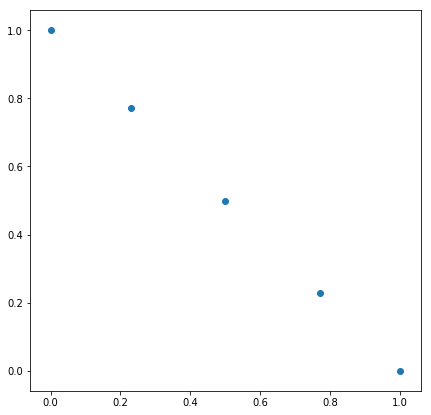

In [5]:
plt.figure(figsize=(7, 7))
plt.scatter(res[0], res[1])

In [6]:
t = np.linspace(0,1, 10)
w1 = np.array([1, 0])[:, None] 
w2 = np.array([0, 1])[:, None] 
# mu = np.array([0., 0.])[:, np.newaxis]
mu = (w1 + w2)/2
# print(w1)
# print(w2)
res = f(t, mu, w1, w2)

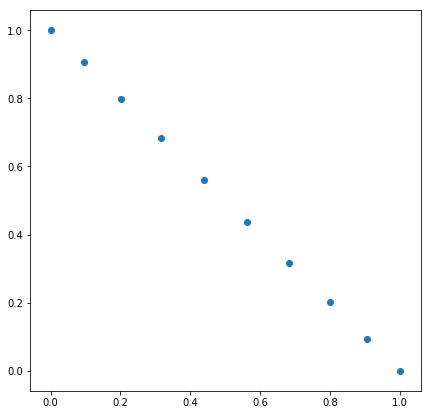

In [7]:
plt.figure(figsize=(7, 7))
plt.scatter(res[0], res[1])

VGG16

Computing mean distance.

Initialization for the layer in NN: 

$W_i \sim U(-\sqrt{k}, \sqrt{k})$
where $k = \frac 1 {N_{in}}$

$N_{in}$ - nubmer of input parameters for the weights. 

$N_{w}$ - numver of weights in the layer.

mean square dist between two layers in Linear layer:

$E [dist^2(L^1, L^2)] = E\sum_i (L_1^i-L_i^2)^2 = N_{w} (2 E (L_i^1)^2) = 2 N_{w} \frac{ \left (2 \sqrt k \right )^2} {12}  = \frac {2 N_{w}} {3 N_{in}}$

for convolution layer:

$E [dist^2(L^1, L^2)] = E\sum_i (L_1^i-L_i^2)^2 = N_{w} (2 E (L_i^1)^2) = 2 N_{w} \left (\sqrt \frac 2 {n} \right )$

where n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels

In [8]:
# # distance for VGG16 network:
# DIST = 0
# i=1
# for m in model.modules():
#     if isinstance(m, torch.nn.Conv2d):
#         print(i, m)
#         i+=1
#         N_in = m.in_channels*np.prod(m.kernel_size)
#         n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
#         N_w = np.prod(m.weight.shape)
# #         +np.prod(m.bias.shape)
#         print('N_in', N_in)
#         print('N_w', N_w)
#         DIST+=2*N_w*2/n
#     if isinstance(m, torch.nn.Linear):
#         print(i, m)
#         i+=1
#         N_in = m.in_features
#         N_w = np.prod(m.weight.shape)+np.prod(m.bias.shape)
#         print('N_in', N_in)
#         print('N_w', N_w)
#         DIST+=2/3*float(N_w)/float(N_in)
        

# print()        
# print('Distance', (np.sqrt(DIST)))

In [9]:
def distance(model1, model2):
    par1 = np.concatenate([p.data.cpu().numpy().ravel() for p in model1.parameters()])
    par2 = np.concatenate([p.data.cpu().numpy().ravel() for p in model2.parameters()])
    u = par2 - par1
    dx = np.linalg.norm(u)
    return dx

In [10]:
def get_vector(model1):
    par1 = np.concatenate([p.data.cpu().numpy().ravel() for p in model1.parameters()])
    return par1

In [11]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
rcParams['figure.dpi'] = 100

In [12]:
def get_model(W, B, architecture):
    model_sampled = architecture.base(num_classes=10, **architecture.kwargs)
    model_samples = np.array(W) #.cpu().data.numpy()
    SIZE = model_sampled.middle_dim

    offset = 0
    for parameter in list(model_sampled.parameters())[:-1]:
        size = int(np.prod(parameter.size())/SIZE)
        value = model_samples[:, offset:offset+size]
        if size==10 or size==1:
             value = value.T
#         print(value.shape)
        value = value.reshape(parameter.size())
#         print(value.shape)
        parameter.data.copy_(torch.from_numpy(value))
        offset += size

    list(model_sampled.parameters())[-1].data.copy_(B.mean(0)) #torch.from_numpy(
    
    return model_sampled

def test(model):
    criterion = F.cross_entropy
    regularizer = None 
    train_res = utils.test(loaders['train'], model, criterion, regularizer)
    test_res = utils.test(loaders['test'], model, criterion, regularizer) 
    print(train_res)
    print(test_res)

def samples(model):
    p1 = list(model.parameters())[0].data.cpu().numpy()
    p2 = list(model.parameters())[1].data.cpu().numpy()
    p3 = list(model.parameters())[2].transpose(0,1).data.cpu().numpy()
    samples = np.hstack([p1, p2[:, None], p3])
    
    return samples

In [13]:
def plot_singl_values(model1, model2, plot=False):
    W11 = list(model1.parameters())[0].data.numpy()
    W12 = list(model1.parameters())[2].data.numpy()
    W21 = list(model2.parameters())[0].data.numpy()
    W22 = list(model2.parameters())[2].data.numpy()

    _, s11, _ = np.linalg.svd(W11)
    _, s12, _ = np.linalg.svd(W12)
    _, s21, _ = np.linalg.svd(W21)
    _, s22, _ = np.linalg.svd(W22)

    if plot:
        fig, axes = plt.subplots(2, 2,)
        axes[0, 0].set_title('W1 model1')
        axes[0, 0].plot(s11)
        axes[0, 1].set_title('W2 model1')
        axes[0, 1].plot(s12)
        axes[1, 0].set_title('W1 model2')
        axes[1, 0].plot(s21)
        axes[1, 1].set_title('W2 model2')
        axes[1, 1].plot(s22)
        plt.show()
    
    return s11, s12, s21, s22

In [14]:
def look_at_models(model1, model2, model3, model4, architecture):
    
    print("distance between train models", distance(model1, model2))
    print("distance between initial models", distance(model3, model4))
    print("how far model1 go", distance(model1, model3))
    print("how far model2 go", distance(model2, model4))
    
    rcParams['figure.figsize'] = 12, 10
    rcParams['figure.dpi'] = 100
    
    print('initial singular values')
    s111, s12, s21, s22 = plot_singl_values(model3, model4, plot=False)
    
    print('train singular values')
    s112, s12, s21, s22 = plot_singl_values(model1, model2, plot=False)
    
    print('singular values distribution')
    plt.hist(s111, bins = 50, density=False);
    plt.hist(s112, bins = 50, density=False);
    plt.show()
    
    sns.kdeplot(s111, shade=True,  cbar=True)
    sns.kdeplot(s112, shade=True,  cbar=True)
    plt.show()
    
    print('train models eigenvector heatmap')
    heat_image(model1)
    heat_image(model2)
    
    
    print('scalar product between train models')
    w1 = get_vector(model1)
    w2 = get_vector(model2)
    print('norms w1, w2', np.linalg.norm(w1), np.linalg.norm(w2))
    print('cos', (w1*w2).sum()/(np.linalg.norm(w1)*np.linalg.norm(w2)))
    
    rcParams['figure.dpi'] = 50
    
    strong, weak = -5, 500 #237
    print('neurons distributions...')
    S1 = samples(model1)
    S2 = samples(model2)
    S_initial1 = samples(model3)
    S_initial2 = samples(model4)

    print('train distribution in 500 pixel')
    plt.hist(S1[:, strong], bins=50, density=True)
    plt.hist(S2[:, strong], bins=50, density=True)
#     sns.kdeplot(S1[:, strong], shade=True,  cbar=True)
#     sns.kdeplot(S2[:, strong], shade=True,  cbar=True)
    plt.show()
    
    print('train distribution in 1 pixel')
    plt.hist(S1[:, weak], bins=50, density=True)
    plt.hist(S2[:, weak], bins=50, density=True)
#     sns.kdeplot(S1[:, weak], shade=True,  cbar=True)
#     sns.kdeplot(S2[:, weak], shade=True,  cbar=True)
    plt.show()
    
    print('distribution in 500 pixel, train and initial model1 ')
    plt.hist(S_initial1[:, strong], bins=50, density=True)
    plt.hist(S1[:, strong], bins=50, density=True)
#     sns.kdeplot(S_initial1[:, strong], shade=True,  cbar=True)
#     sns.kdeplot(S1[:, strong], shade=True,  cbar=True)
    plt.show()
    
    print('distribution in 500 pixel, train and initial model2 ')
    plt.hist(S_initial2[:, strong], bins=50, density=True)
    plt.hist(S2[:, strong], bins=50, density=True)
#     sns.kdeplot(S_initial2[:, strong], shade=True,  cbar=True)
#     sns.kdeplot(S2[:, strong], shade=True,  cbar=True)
    plt.show()
    
    print('distribution in 1 pixel, train and initial model1 ')
    plt.hist(S1[:, weak], bins=50, density=True)
    plt.hist(S_initial1[:, weak], bins=50, density=True)
    
#     sns.kdeplot(S1[:, weak], shade=True,  cbar=True)
#     sns.kdeplot(S_initial1[:, weak], shade=True,  cbar=True)
    plt.show()
    
    print('distribution in 1 pixel, train and initial model2 ')
    plt.hist(S2[:, weak], bins=50, density=True)
    plt.hist(S_initial2[:, weak], bins=50, density=True)
#     sns.kdeplot(S2[:, weak], shade=True,  cbar=True)
#     sns.kdeplot(S_initial2[:, weak], shade=True,  cbar=True)
    plt.show()
    
    print('initial distributions in 1 pixel')
    plt.hist(S_initial1[:, weak], bins=50, density=True)
    plt.hist(S_initial2[:, weak], bins=50, density=True)
#     sns.kdeplot(S_initial1[:, weak], shade=True,  cbar=True)
#     sns.kdeplot(S_initial2[:, weak], shade=True,  cbar=True)
    plt.show()
    
    print('finding means for the models...')
    SE = (S1+S2)/2
    S1_mean = np.repeat(S1.mean(0, keepdims = True), repeats=model1.middle_dim, axis=0)
    S2_mean = np.repeat(S2.mean(0, keepdims = True), repeats=model1.middle_dim, axis=0)
    SE_mean = np.repeat(SE.mean(0, keepdims = True), repeats=model1.middle_dim, axis=0)
    B1 = list(model1.parameters())[-1].data
    B2 = list(model2.parameters())[-1].data
    BE = (B1+B2)/2
    
    mu1 = get_model(S1_mean, B1, architecture)
    mu2 = get_model(S2_mean, B2, architecture)
    mu = get_model(SE_mean, BE, architecture)
    
    print('test model1')
    test(model1)
    print('test model2')
    test(model2)
    
    print('computing Arc2 model...' )
    model_Arc2 = architecture.base(num_classes=10, **architecture.kwargs)
    for i, (parameter, p1, p2, m1, m2) in enumerate(zip(model_Arc2.parameters(), model1.parameters(), model2.parameters(), 
                                                    mu1.parameters(), mu2.parameters())):    
#     if i!=3:
        parameter.data.copy_(1/2*m1+1/2*m2 +(1/np.sqrt(2))*(p1-m1)+(1/np.sqrt(2))*(p2-m2))
    print('test Arc2')
    test(model_Arc2)
    
    print('computing Arc model...')
    model_Arc = architecture.base(num_classes=10, **architecture.kwargs)
    for i, (parameter, p1, p2, m) in enumerate(zip(model_Arc.parameters(), model1.parameters(), model2.parameters(), mu.parameters())):    
#     if i!=3:
        parameter.data.copy_(m + (1/np.sqrt(2))*(p1-m)+(1/np.sqrt(2))*(p2-m))
    print('test Arc')
    test(model_Arc)
    
    print('computing Lin model...')
    model_Lin = architecture.base(num_classes=10, **architecture.kwargs)
    for parameter, p1, p2 in zip(model_Lin.parameters(), model1.parameters(), model2.parameters()):
        parameter.data.copy_((p1+p2)/2)
    test(model_Lin)
    

In [222]:
S1 = samples(model1)

In [223]:
np.arange(S1.shape[1])[S1.var(0)>1.46826378e-03]

array([237, 265, 268, 293, 294, 296, 297, 321, 347, 348, 349, 486, 488,
       489, 516, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794])

In [224]:
W11 = list(model1.parameters())[0].data.numpy()
A = W11.T@W11
l, v = np.linalg.eig(A)
v = np.real(v)
l = np.real(l)

In [225]:
v.shape

(784, 784)

In [234]:
W11 = list(model1.parameters())[0].data.numpy()

In [235]:
W11

array([[ 0.0215914 , -0.02444528,  0.02664132, ..., -0.02349961,
         0.00422057,  0.00097155],
       [-0.03125322, -0.03198559,  0.00243268, ..., -0.01567274,
        -0.01603959, -0.02188832],
       [ 0.00029307, -0.01406164, -0.00571612, ...,  0.01285221,
         0.01222814,  0.00526268],
       ...,
       [ 0.02597238, -0.01956961,  0.02938085, ..., -0.0186848 ,
        -0.02120877, -0.00217338],
       [ 0.02550497,  0.02586438,  0.01871128, ...,  0.02769009,
        -0.01623153, -0.01243641],
       [ 0.00699281,  0.02871385, -0.02861437, ...,  0.02451301,
         0.00132173,  0.00583052]], dtype=float32)

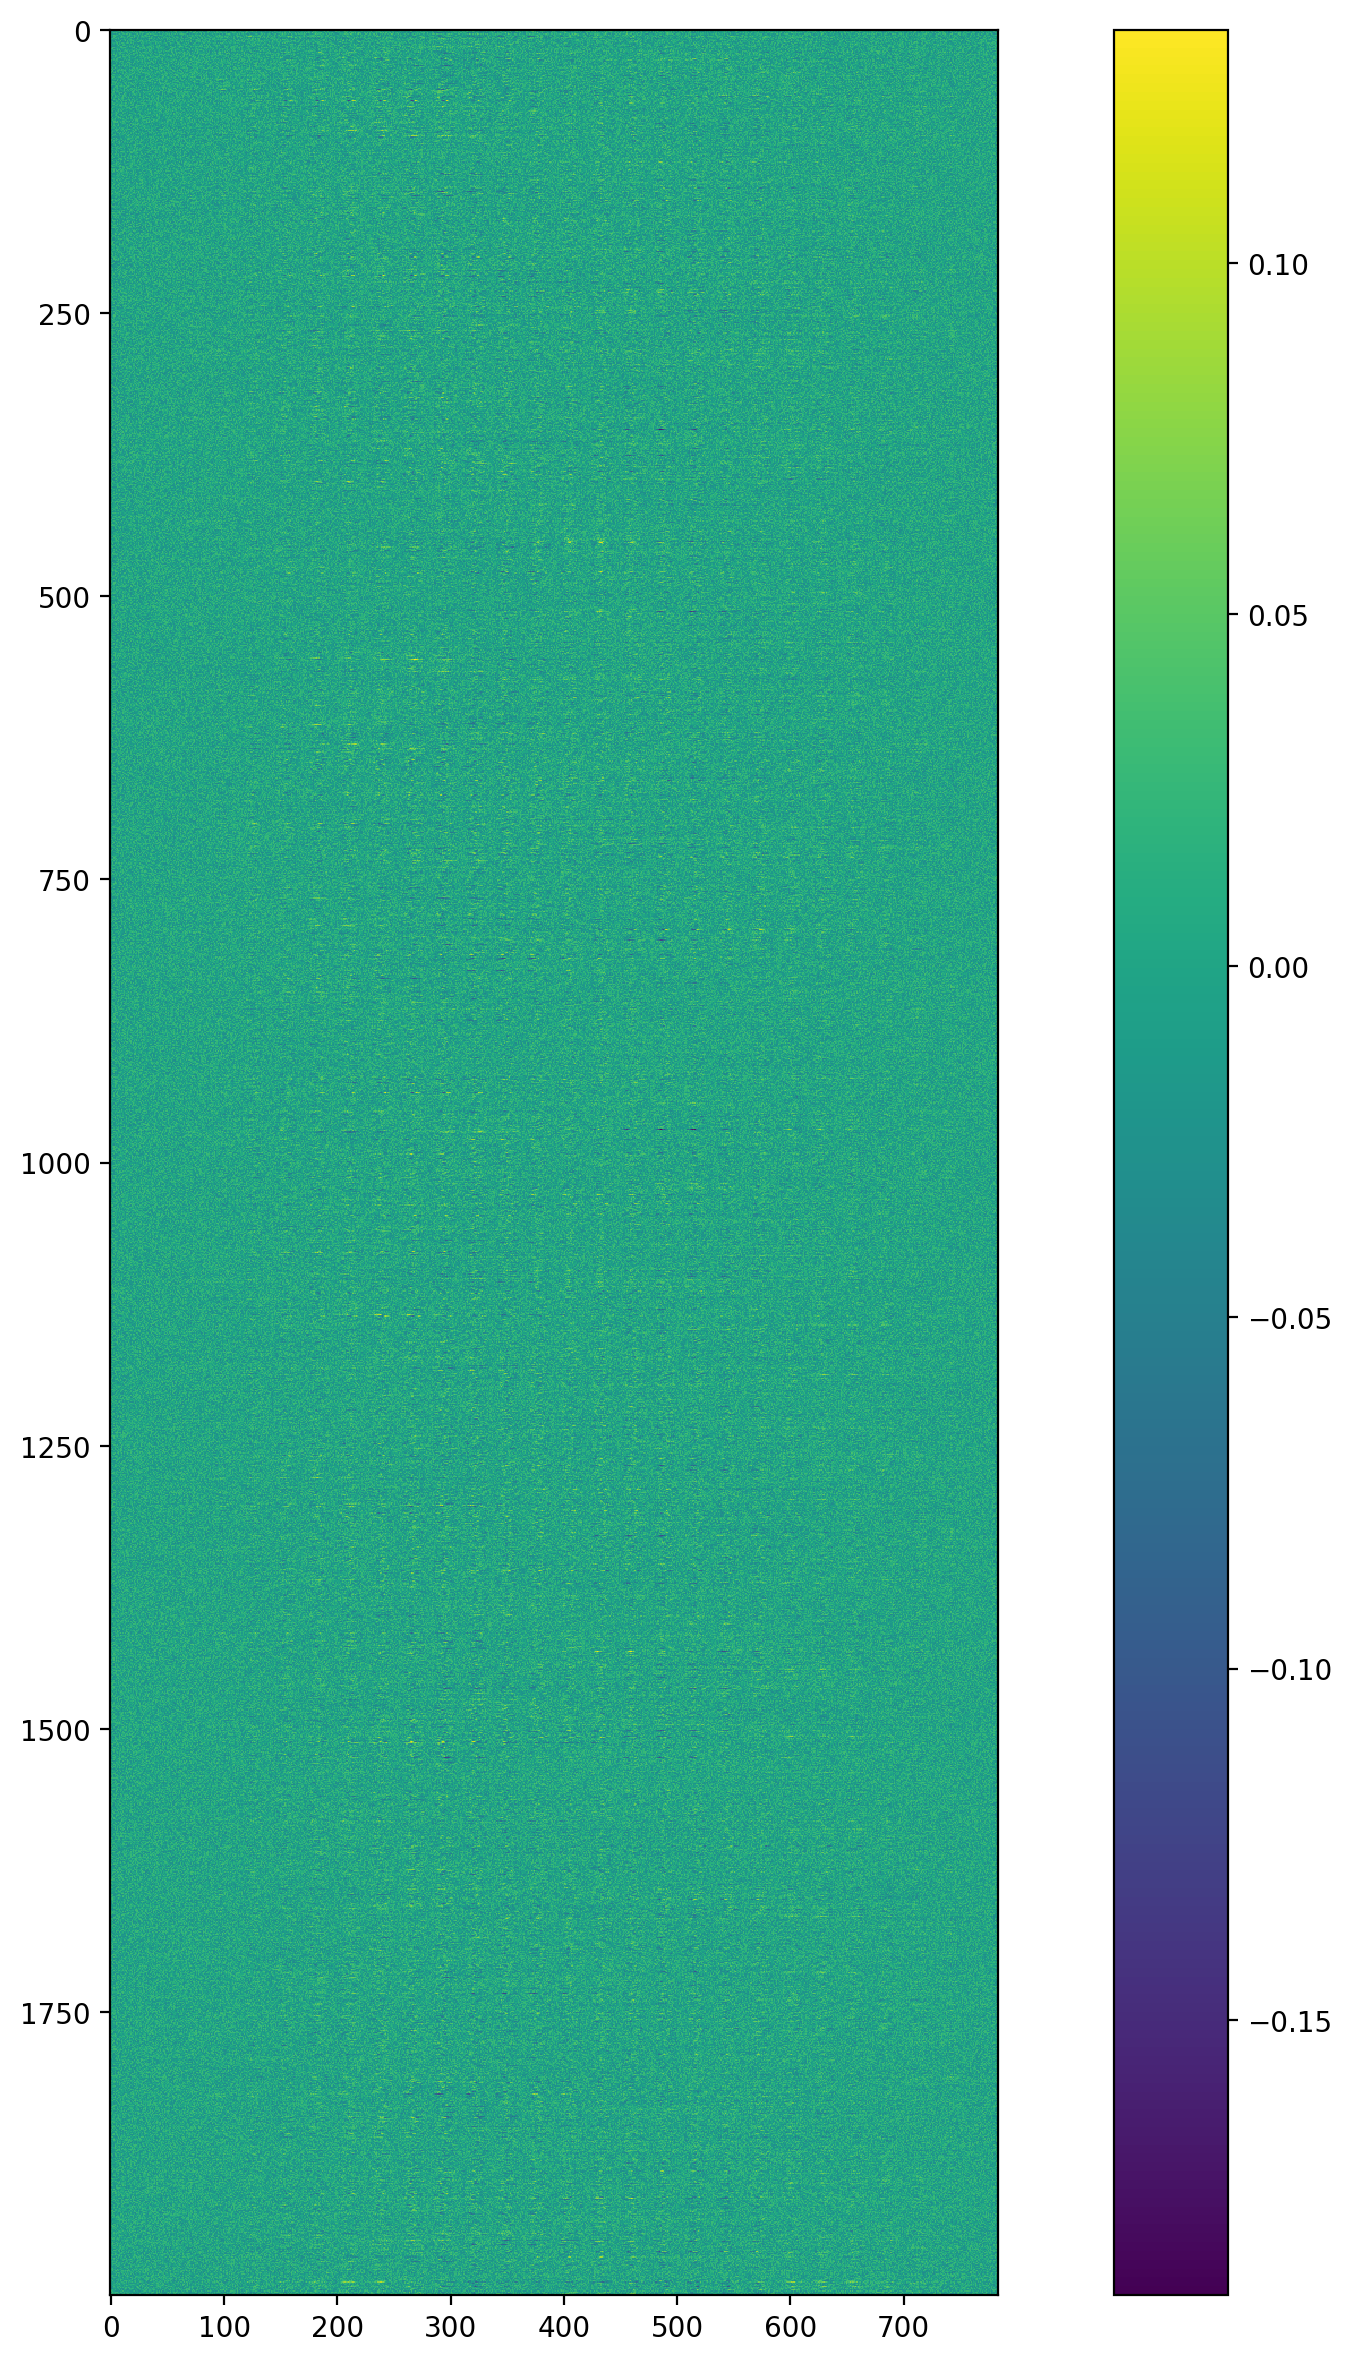

In [236]:
rcParams['figure.dpi'] = 200
plt.imshow(W11)
plt.colorbar()

In [15]:
def get_ev(model):
    W11 = list(model.parameters())[0].data.numpy()
    A = W11.T @ W11
    l, v = np.linalg.eig(A)
    v = np.real(v)
    l = np.real(l)
    return v, l
    

def heat_image(model):
    
    ev, e = get_ev(model)
    N = 5
    fig, ax = plt.subplots(1, N)
    
#     W11 = list(model.parameters())[0].data.numpy()
#     _, _, vh = np.linalg.svd(W11)
#     ev = vh.T @ ev
#     ev = ev>ev.mean()
    
    
    rcParams['figure.figsize'] = 15, 15
    rcParams['figure.dpi'] = 100
    
    for ind, (im, l) in enumerate(zip(ev.T[:N], e[:N])):
        im = np.abs(im.reshape((28, 28)))

        ax[ind].imshow(im)
        ax[ind].set_title(l)
        
#     plt.colorbar()
#     plt.axis('off')
    plt.show()

In [16]:
# heat_image(model1)

In [17]:
# heat_image(model2)

In [18]:
#  u, s11, v = np.linalg.svd(W11)

In [19]:
# u.shape, v.shape

In [20]:
# v.T@v

In [21]:
# rcParams['figure.dpi'] = 50
# v, l = get_ev(model1)
# im = np.abs(v[:, 12].reshape((28, 28)))
# plt.imshow(im)
# plt.colorbar()

In [22]:
# v, l = get_ev(model2)
# im = np.abs(v[:, 12].reshape((28, 28)))
# plt.imshow(im)
# plt.colorbar()

Files already downloaded and verified
You are going to run models on the test set. Are you sure?
Files already downloaded and verified
distance between train models 72.79695
distance between initial models 81.691315
how far model1 go 45.361496
how far model2 go 45.40977
initial singular values
train singular values
singular values distribution


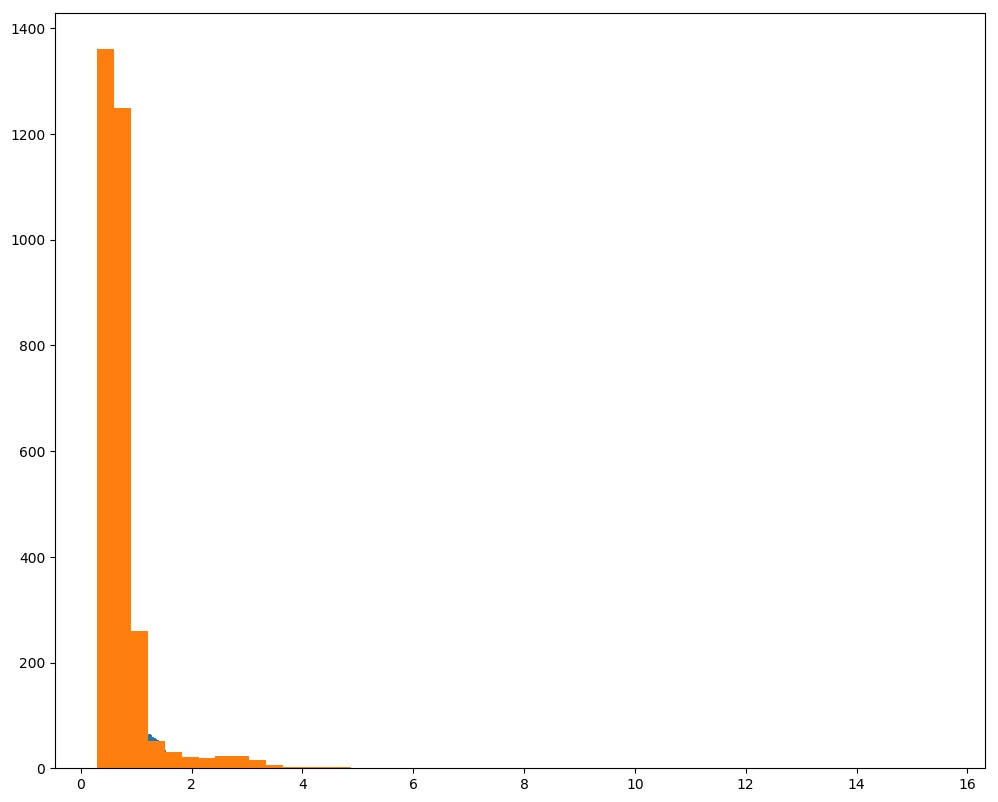

/home/anokhin/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


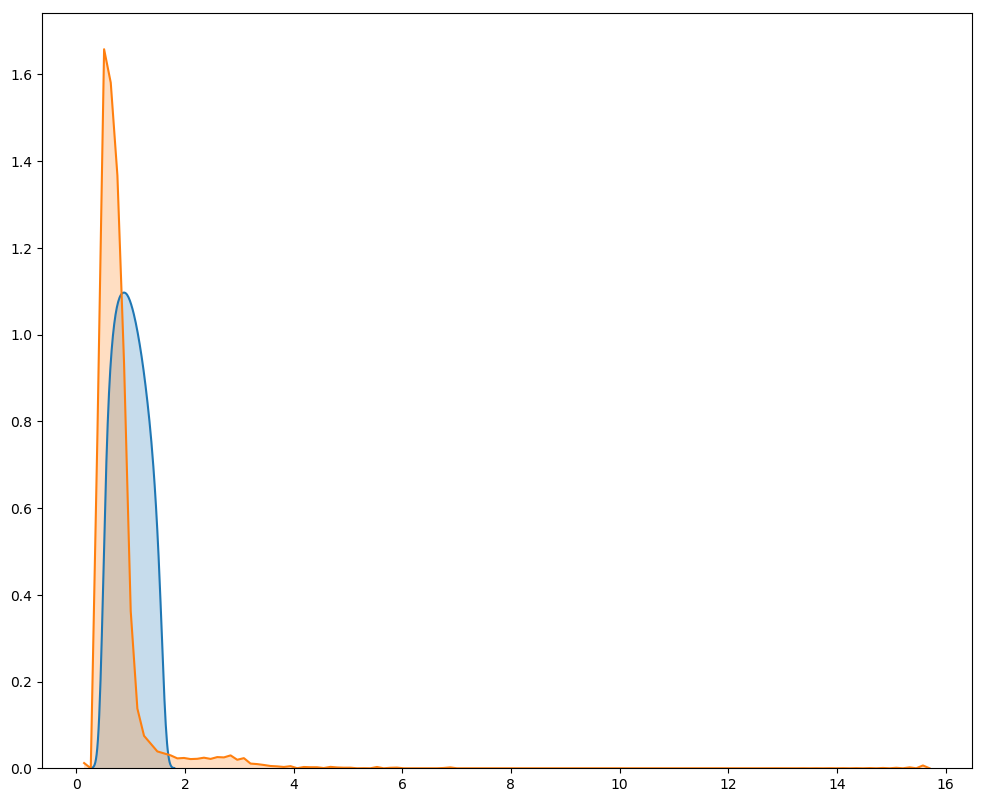

train models eigenvector heatmap


ValueError: cannot reshape array of size 3072 into shape (28,28)

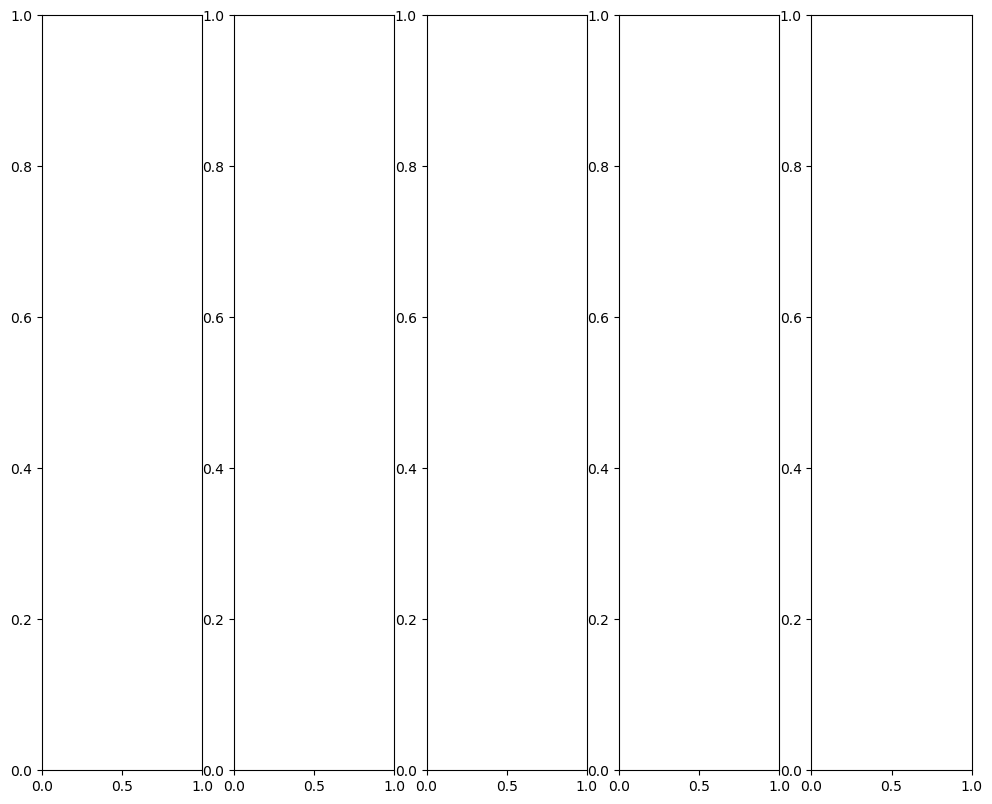

In [23]:
loaders, num_classes = data.loaders(
    "CIFAR10",
    "data",
    128,
    1,
    "VGG",
    True)

criterion = F.cross_entropy
regularizer = None 

architecture = getattr(models, "LinearOneLayerCF") #LinearOneLayer LogRegression
model1 = architecture.base(num_classes=10, **architecture.kwargs)
model2 = architecture.base(num_classes=10, **architecture.kwargs)
model3 = architecture.base(num_classes=10, **architecture.kwargs)
model4 = architecture.base(num_classes=10, **architecture.kwargs)

model1.load_state_dict(torch.load('curves/LinearOneLayerCF/AdamGaussianInit/curve1/checkpoint-200.pt')['model_state'])
model2.load_state_dict(torch.load('curves/LinearOneLayerCF/AdamGaussianInit/curve2/checkpoint-200.pt')['model_state'])

model3.load_state_dict(torch.load('curves/LinearOneLayerCF/AdamGaussianInit/curve1/checkpoint-0.pt')['model_state'])
model4.load_state_dict(torch.load('curves/LinearOneLayerCF/AdamGaussianInit/curve2/checkpoint-0.pt')['model_state'])

look_at_models(model1, model2, model3, model4, architecture)

In [25]:
architecture = getattr(models, "LinearOneLayer")

model = architecture.base(num_classes=10, **architecture.kwargs)

loaders, num_classes = data.loaders(
    "MNIST",
    "data",
    128,
    1,
    "VGG",
    True)

criterion = F.cross_entropy
regularizer = None 


architecture = getattr(models, "LinearOneLayer") #LinearOneLayer LogRegression
model1 = architecture.base(num_classes=10, **architecture.kwargs)
model2 = architecture.base(num_classes=10, **architecture.kwargs)
model3 = architecture.base(num_classes=10, **architecture.kwargs)
model4 = architecture.base(num_classes=10, **architecture.kwargs)

You are going to run models on the test set. Are you sure?


distance between train models 39.930042
distance between initial models 36.605488
how far model1 go 14.446777
how far model2 go 14.435287
initial singular values
train singular values
singular values distribution


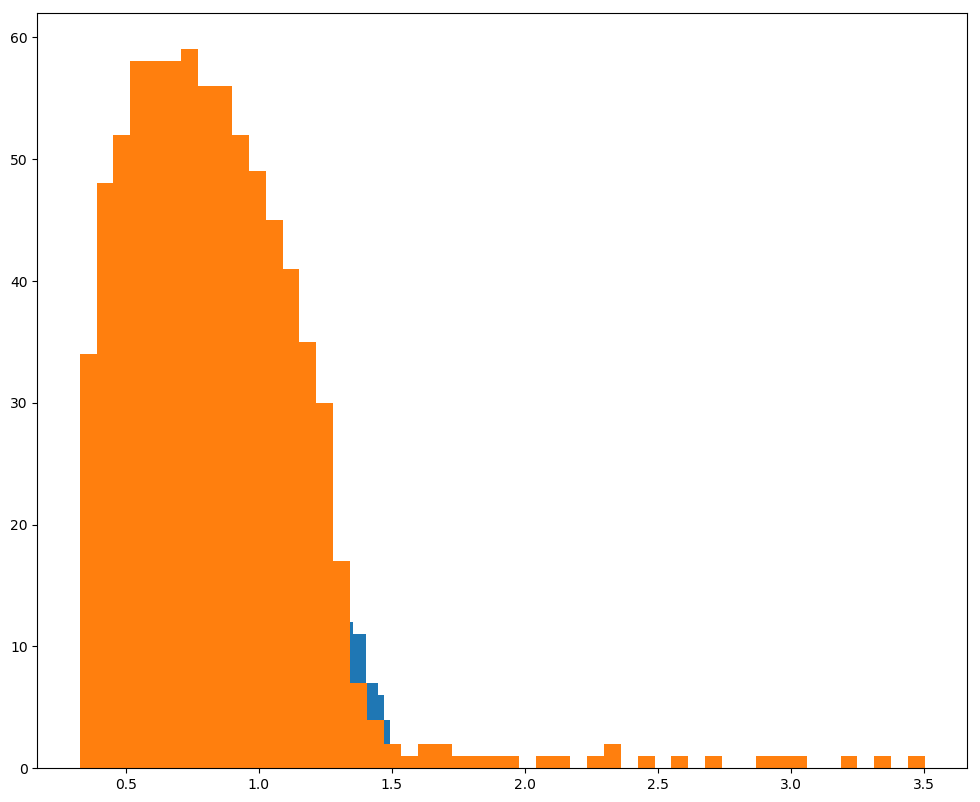

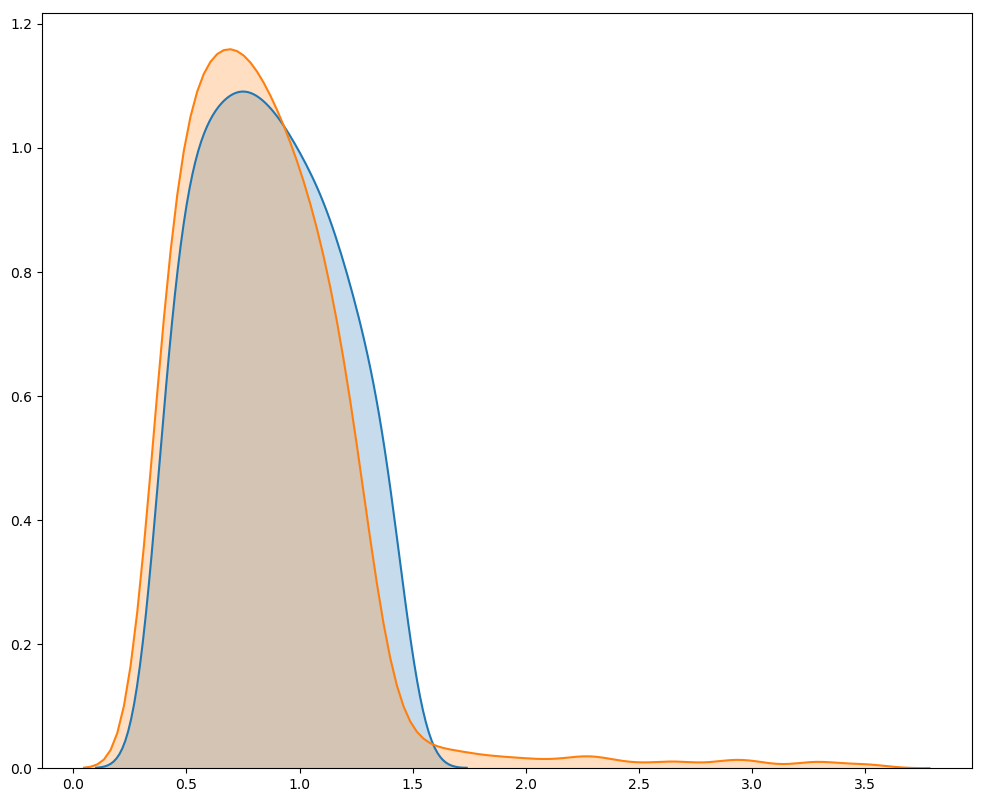

train models eigenvector heatmap


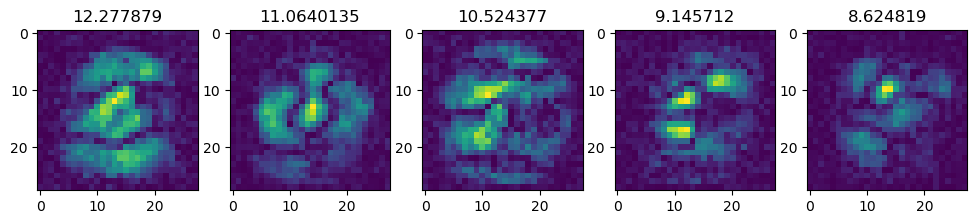

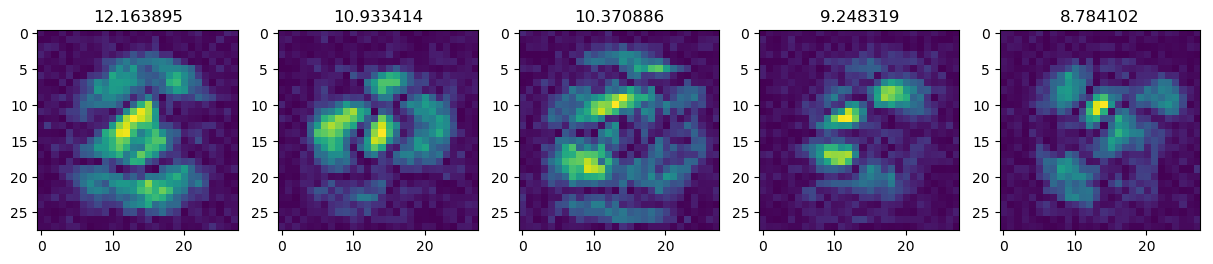

scalar product between train models
norms w1, w2 28.272017 28.281408
cos 0.0029618354
neurons distributions...
train distribution in 500 pixel


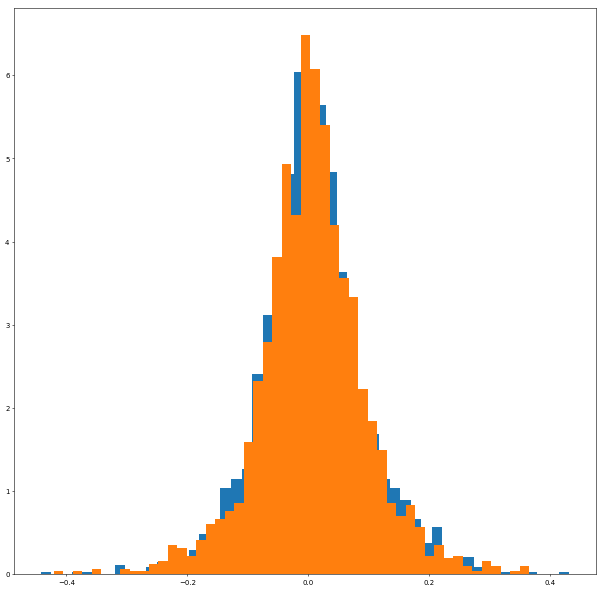

train distribution in 1 pixel


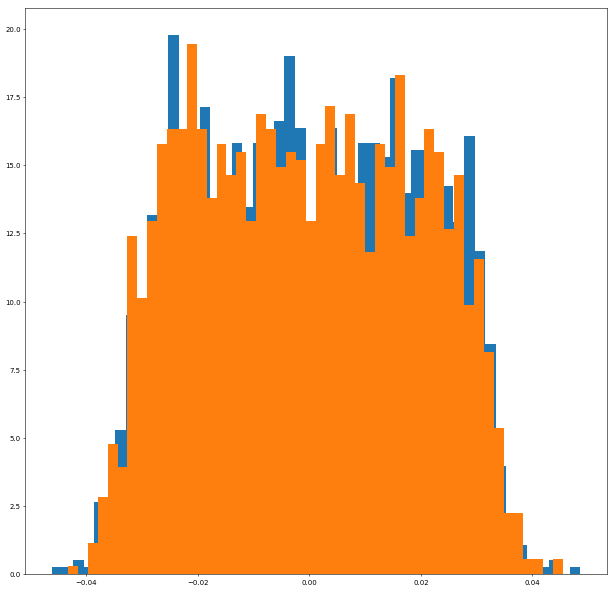

distribution in 500 pixel, train and initial model1 


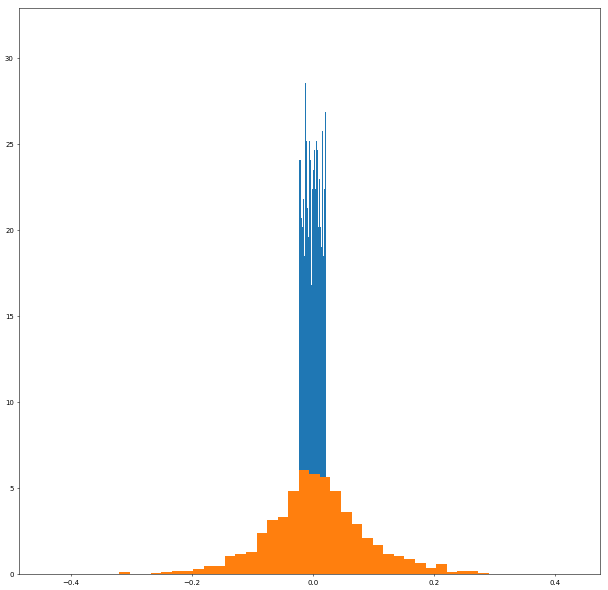

distribution in 500 pixel, train and initial model2 


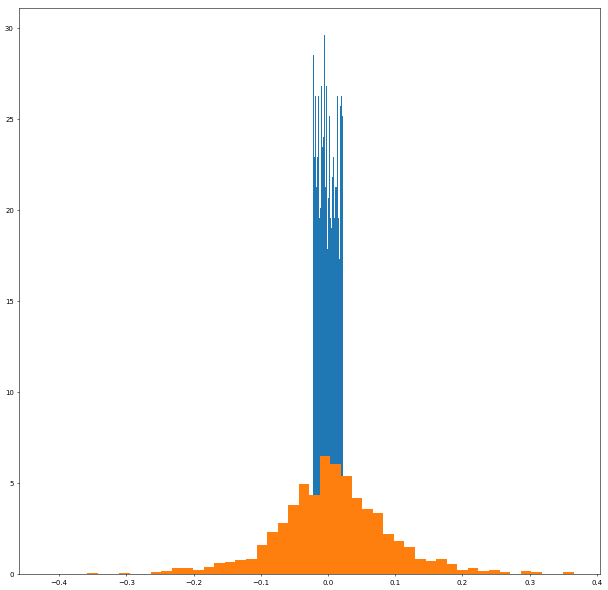

distribution in 1 pixel, train and initial model1 


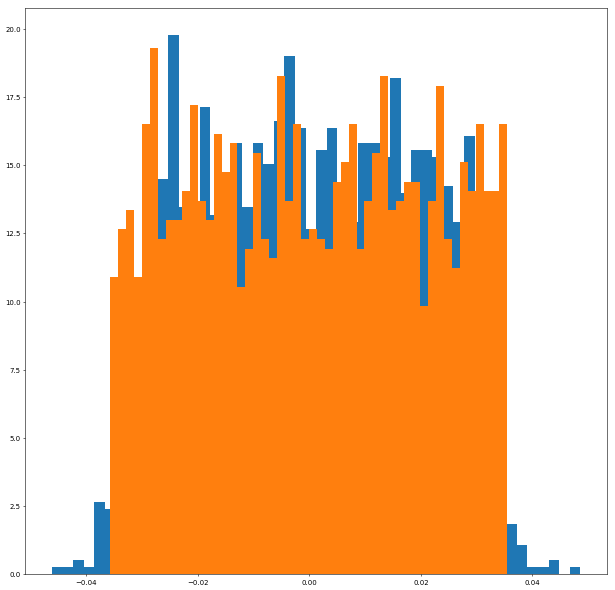

distribution in 1 pixel, train and initial model2 


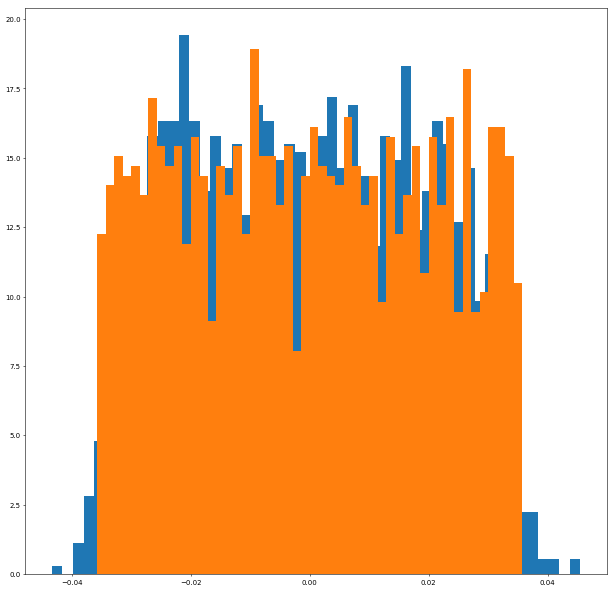

initial distributions in 1 pixel


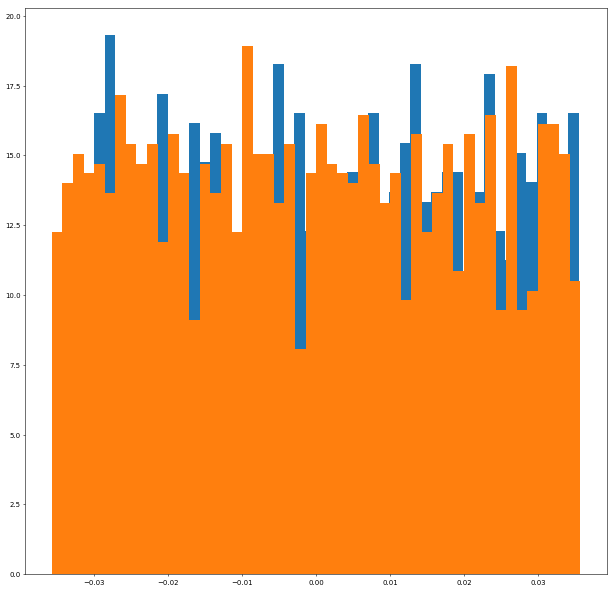

finding means for the models...
test model1
{'nll': 0.04309506347576777, 'loss': 0.04309506347576777, 'accuracy': 99.01833333333333}
{'nll': 0.07010492646694183, 'loss': 0.07010492646694183, 'accuracy': 97.96}
test model2
{'nll': 0.04299221677382787, 'loss': 0.04299221677382787, 'accuracy': 99.02166666666666}
{'nll': 0.06919561448097229, 'loss': 0.06919561448097229, 'accuracy': 97.81}
computing Arc2 model...
test Arc2
{'nll': 0.08462955686648686, 'loss': 0.08462955686648686, 'accuracy': 97.75833333333334}
{'nll': 0.10701955115795135, 'loss': 0.10701955115795135, 'accuracy': 96.98}
computing Arc model...
test Arc
{'nll': 0.08462956198255221, 'loss': 0.08462956198255221, 'accuracy': 97.75833333333334}
{'nll': 0.10701955692768098, 'loss': 0.10701955692768098, 'accuracy': 96.98}
computing Lin model...
{'nll': 0.2622267659028371, 'loss': 0.2622267659028371, 'accuracy': 96.62333333333333}
{'nll': 0.26579342799186706, 'loss': 0.26579342799186706, 'accuracy': 95.97}


In [233]:
model1.load_state_dict(torch.load('curves_mnist/LinearOneLayer/LongTraining//curve5/checkpoint-30.pt')['model_state'])
model2.load_state_dict(torch.load('curves_mnist/LinearOneLayer/LongTraining//curve6/checkpoint-30.pt')['model_state'])

model3.load_state_dict(torch.load('curves_mnist/LinearOneLayer/LongTraining/curve5/checkpoint-0.pt')['model_state'])
model4.load_state_dict(torch.load('curves_mnist/LinearOneLayer/LongTraining/curve6/checkpoint-0.pt')['model_state'])

look_at_models(model1, model2, model3, model4, architecture)

distance between train models 38.974926
distance between initial models 36.631916
how far model1 go 10.696269
how far model2 go 10.6899395
initial singular values
train singular values
singular values distribution


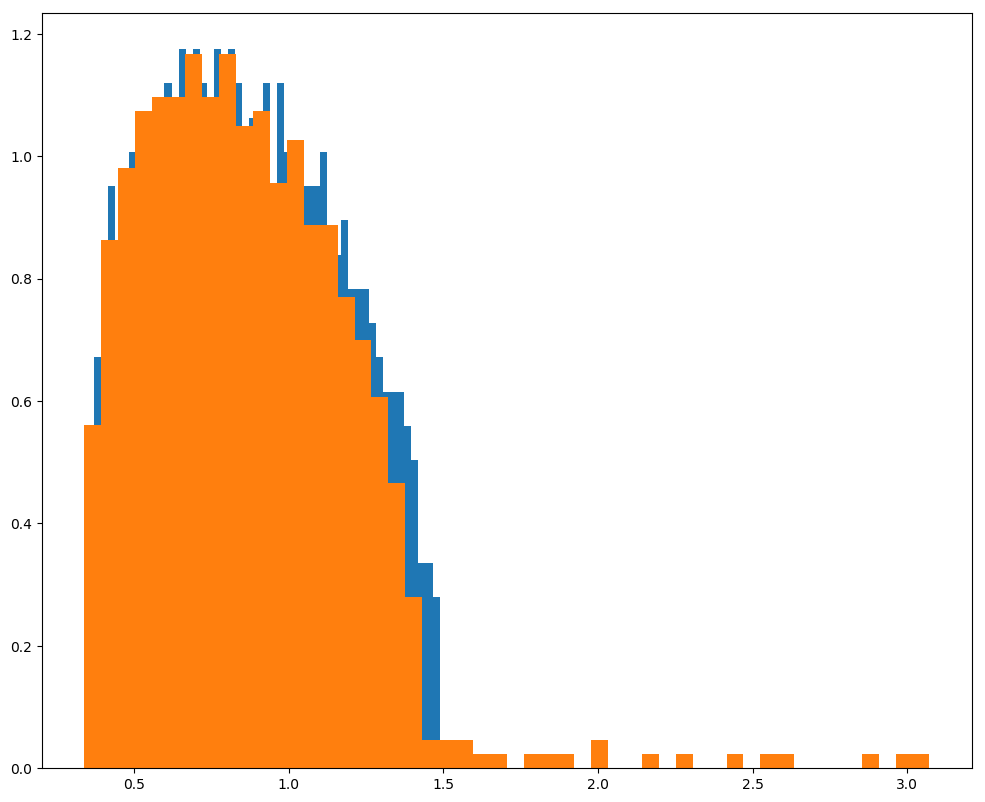

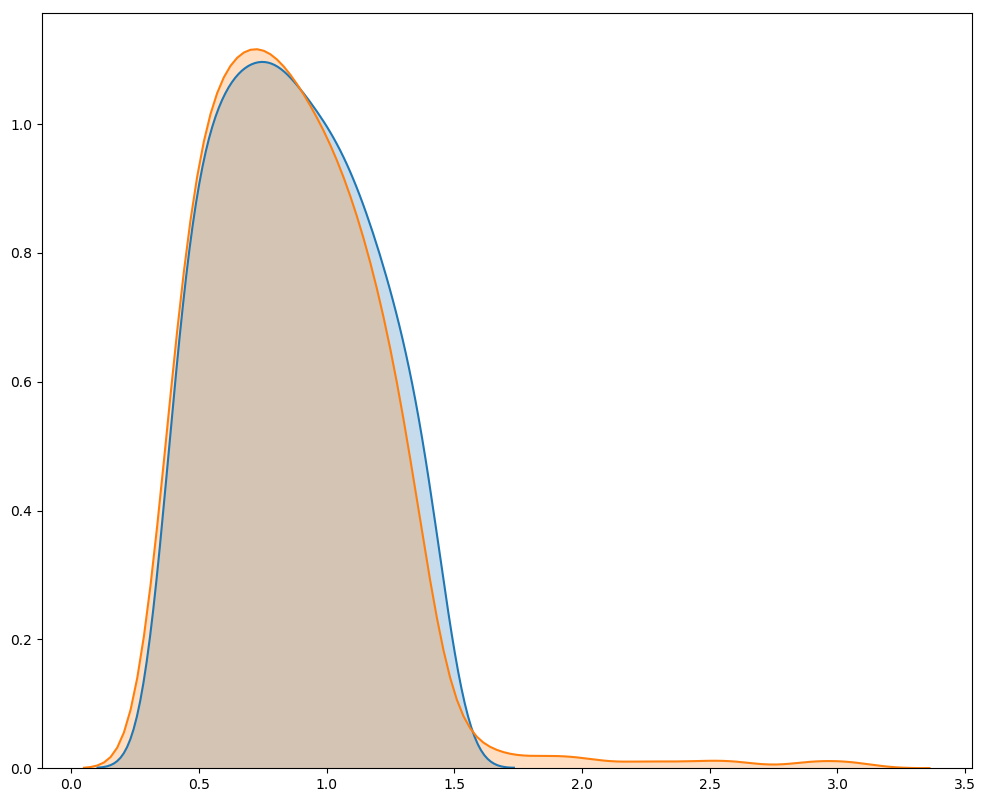

train models eigenvector heatmap


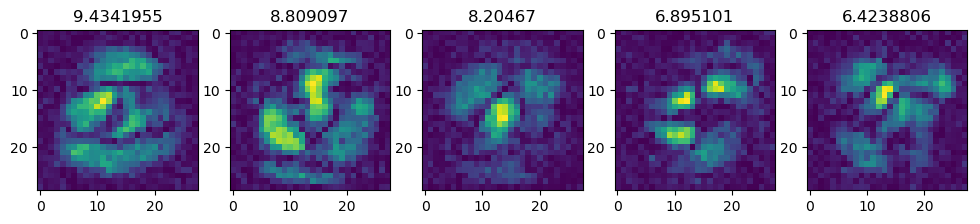

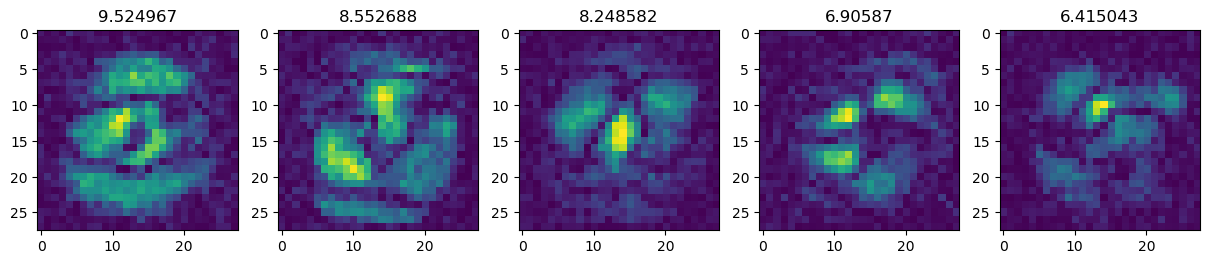

scalar product between train models
norms w1, w2 27.561464 27.576782
cos 0.00070275983
neurons distributions...
train distribution in 500 pixel


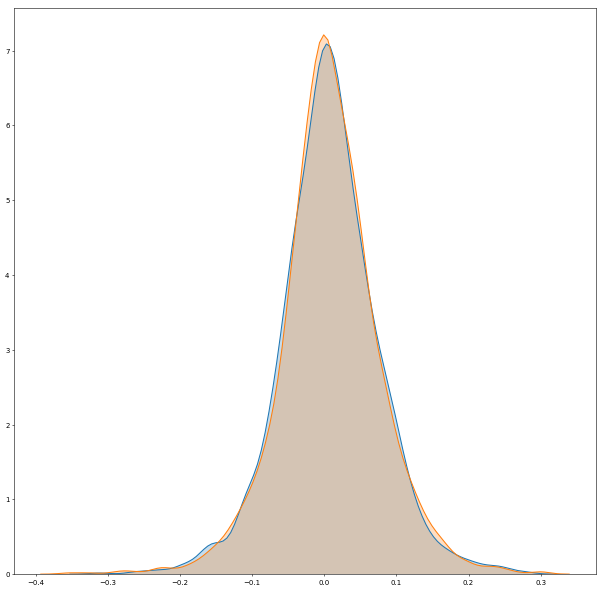

train distribution in 1 pixel


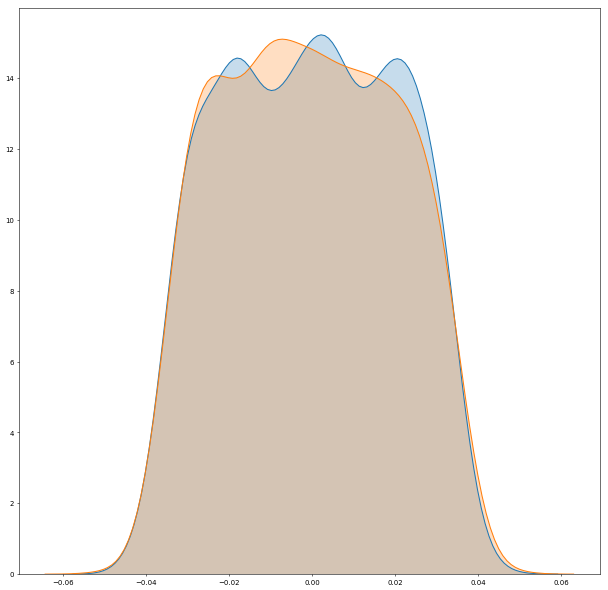

distribution in 500 pixel, train and initial model1 


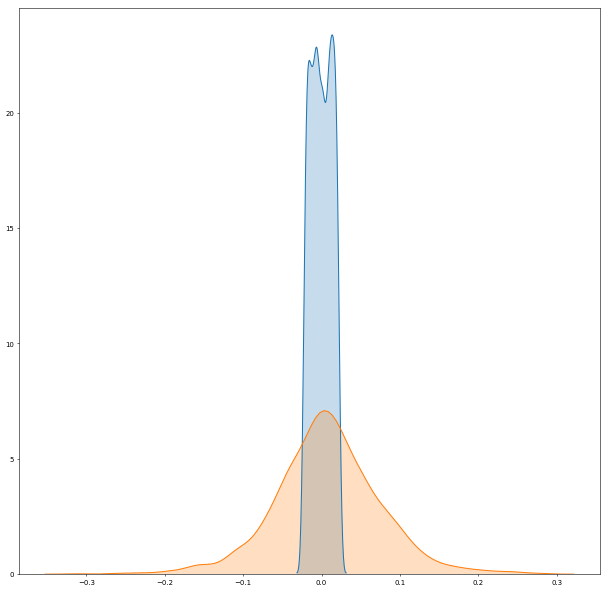

distribution in 500 pixel, train and initial model2 


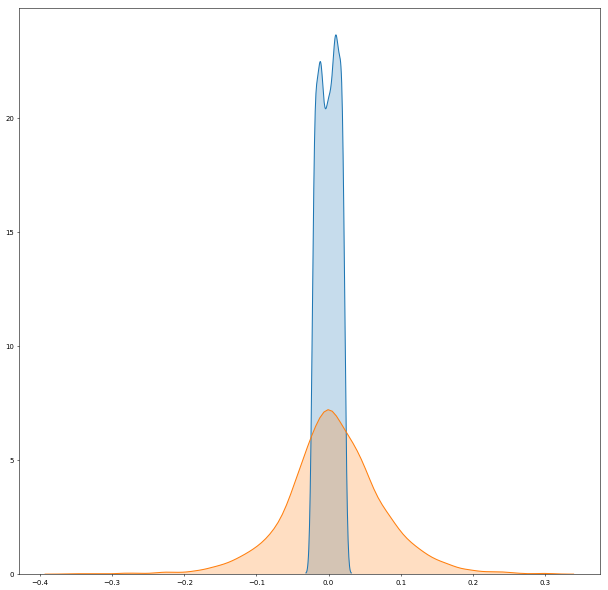

distribution in 1 pixel, train and initial model1 


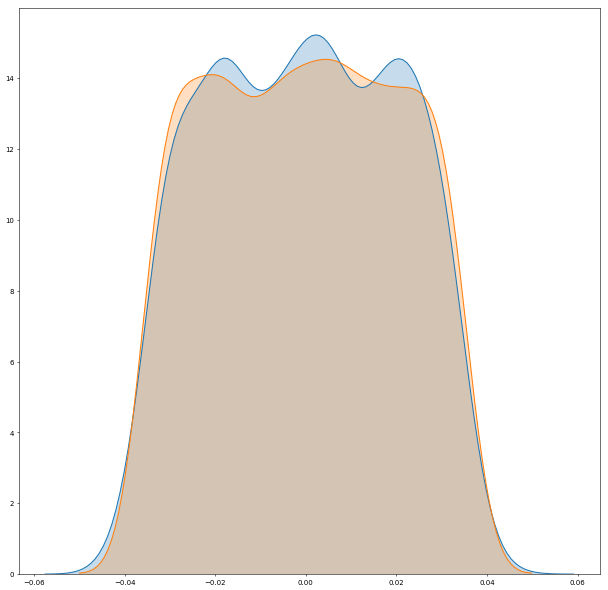

distribution in 1 pixel, train and initial model2 


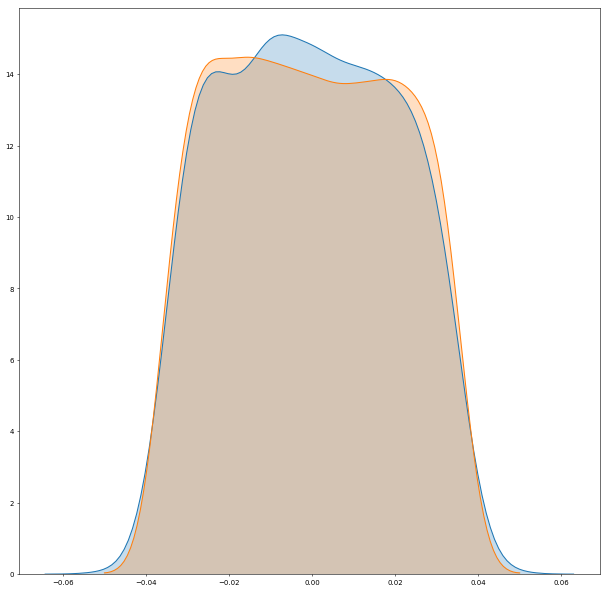

initial distributions in 1 pixel


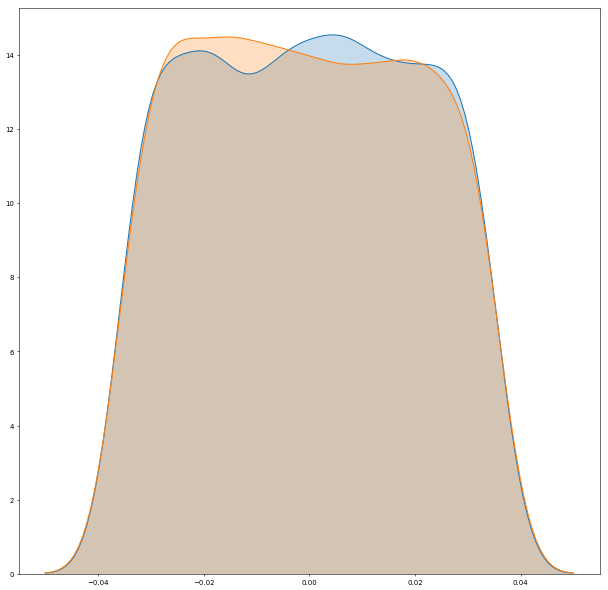

finding means for the models...
test model1
{'nll': 0.09639597692489624, 'loss': 0.09639597692489624, 'accuracy': 97.445}
{'nll': 0.10739255590438843, 'loss': 0.10739255590438843, 'accuracy': 96.91}
test model2
{'nll': 0.09671588237682978, 'loss': 0.09671588237682978, 'accuracy': 97.45833333333333}
{'nll': 0.10824201488494874, 'loss': 0.10824201488494874, 'accuracy': 96.82}
computing Arc2 model...
test Arc2
{'nll': 0.14396326188643774, 'loss': 0.14396326188643774, 'accuracy': 96.07333333333334}
{'nll': 0.15157145409584044, 'loss': 0.15157145409584044, 'accuracy': 95.86}
computing Arc model...
test Arc
{'nll': 0.14396326895157496, 'loss': 0.14396326895157496, 'accuracy': 96.07333333333334}
{'nll': 0.1515714655637741, 'loss': 0.1515714655637741, 'accuracy': 95.86}
computing Lin model...
{'nll': 0.3948885368824005, 'loss': 0.3948885368824005, 'accuracy': 92.82666666666667}
{'nll': 0.388821006155014, 'loss': 0.388821006155014, 'accuracy': 92.82}


In [191]:
model1.load_state_dict(torch.load('curves_mnist/LinearOneLayer/curve5/checkpoint-12.pt')['model_state'])
model2.load_state_dict(torch.load('curves_mnist/LinearOneLayer/curve6/checkpoint-12.pt')['model_state'])

model3.load_state_dict(torch.load('curves_mnist/LinearOneLayer/curve5/checkpoint-0.pt')['model_state'])
model4.load_state_dict(torch.load('curves_mnist/LinearOneLayer/curve6/checkpoint-0.pt')['model_state'])

look_at_models(model1, model2, model3, model4, architecture)

distance between train models 429.59613
distance between initial models 36.60448
how far model1 go 311.4838
how far model2 go 319.50873
initial singular values
train singular values
singular values distribution


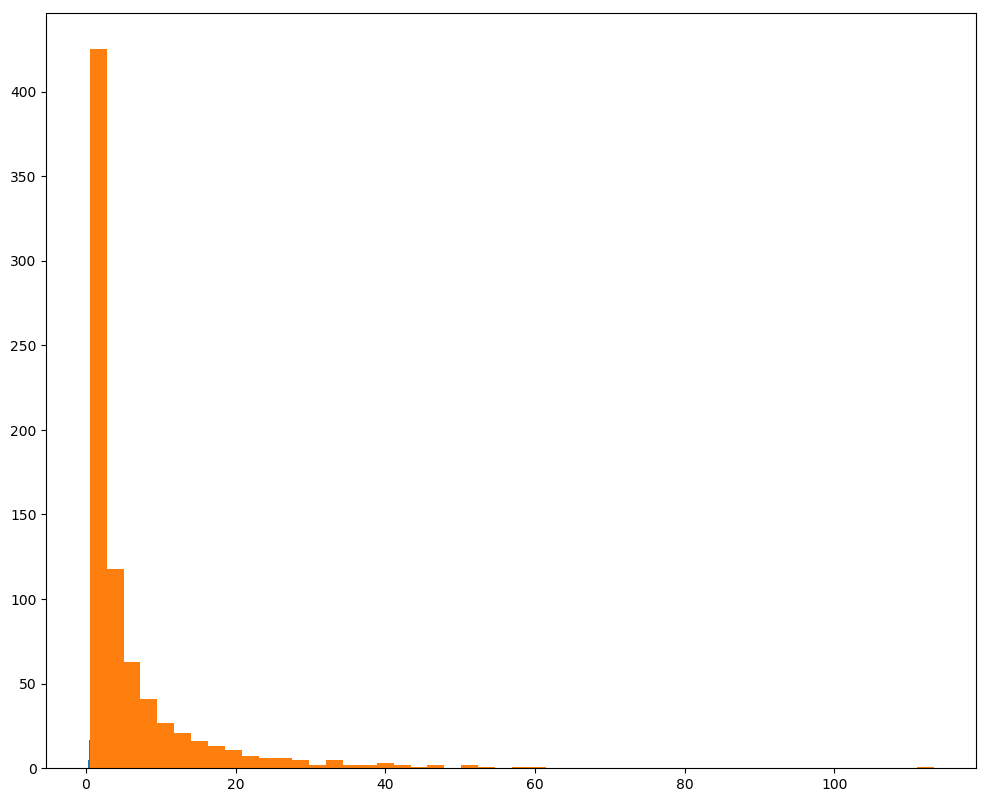

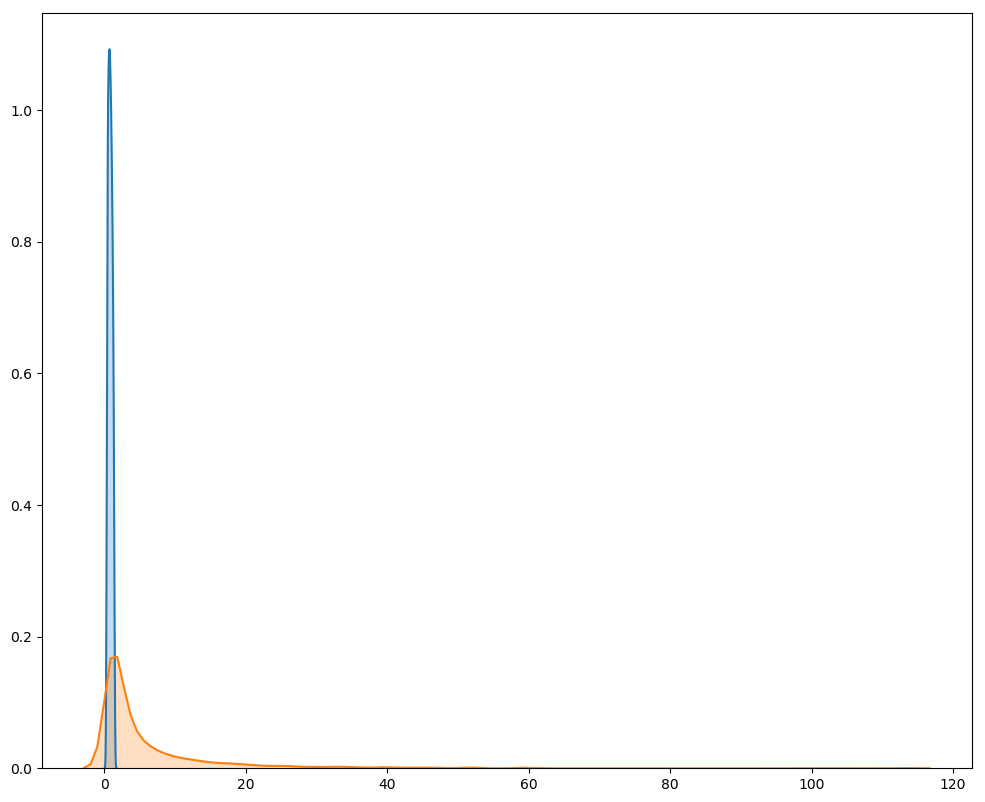

train models eigenvector heatmap


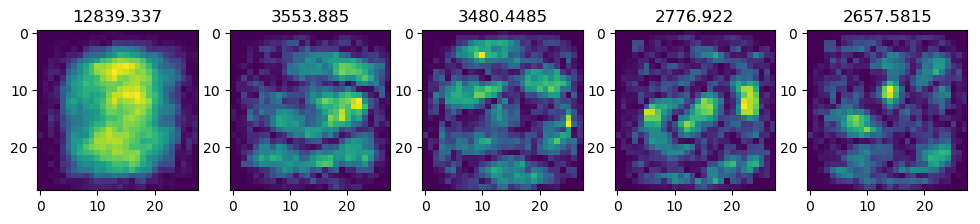

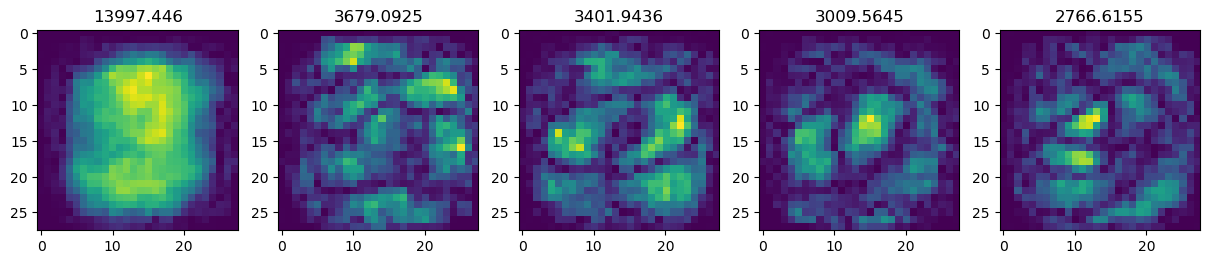

scalar product between train models
norms w1, w2 312.72842 320.72247
cos 0.08030548
neurons distributions...
train distribution in 500 pixel


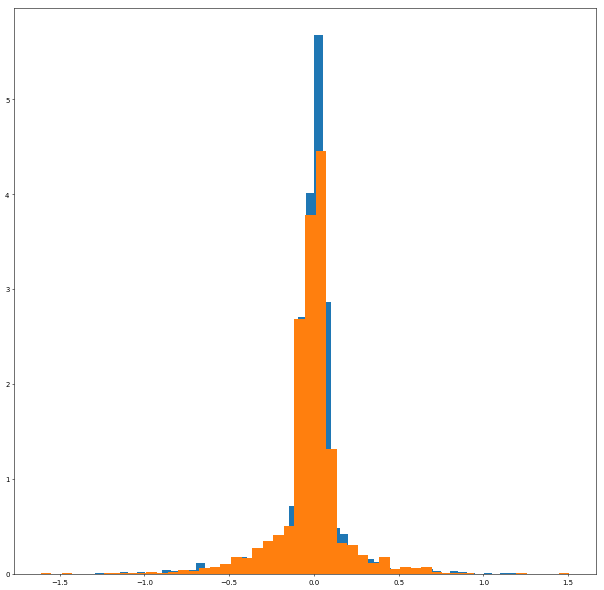

train distribution in 1 pixel


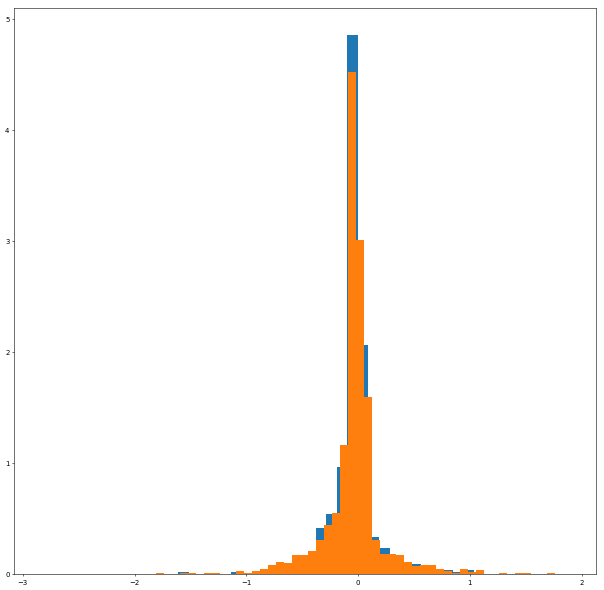

distribution in 500 pixel, train and initial model1 


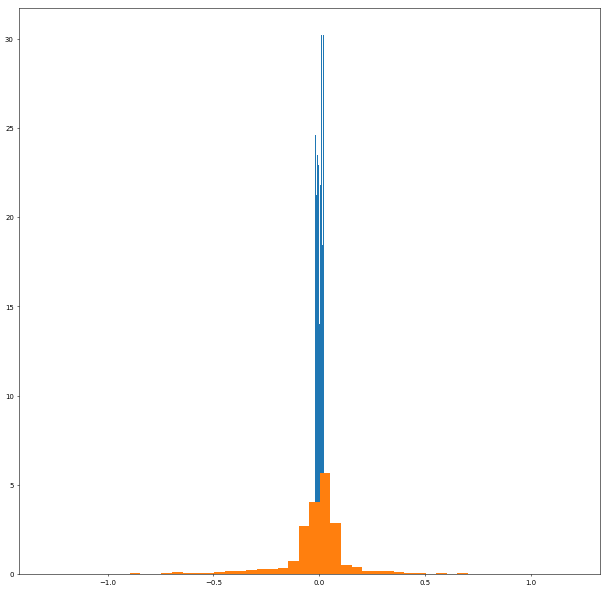

distribution in 500 pixel, train and initial model2 


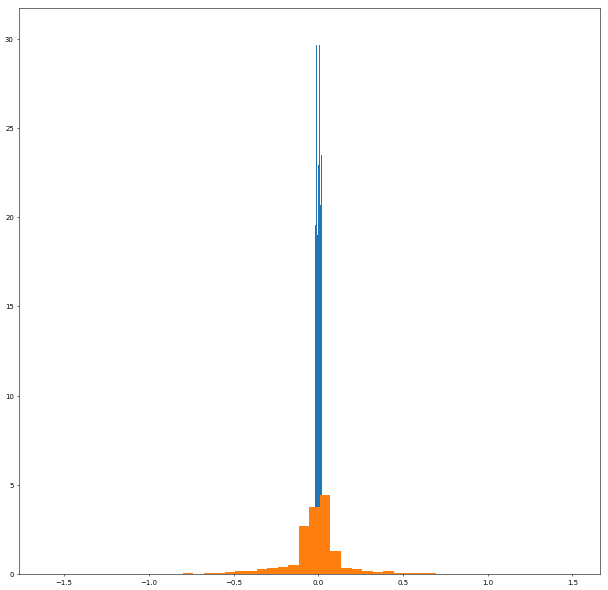

distribution in 1 pixel, train and initial model1 


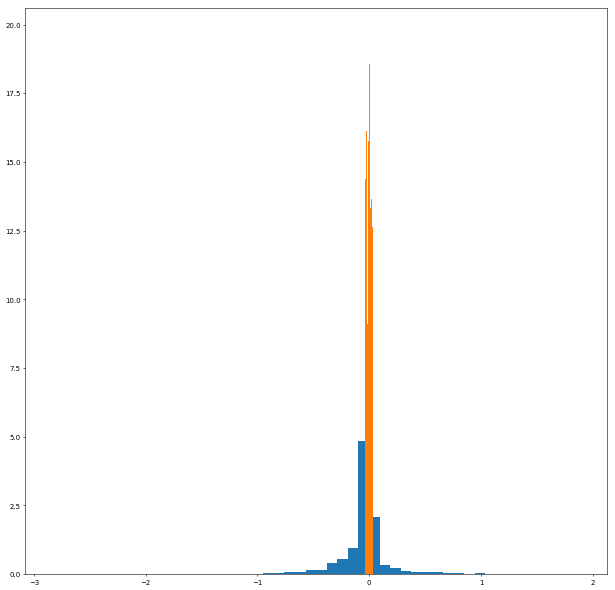

distribution in 1 pixel, train and initial model2 


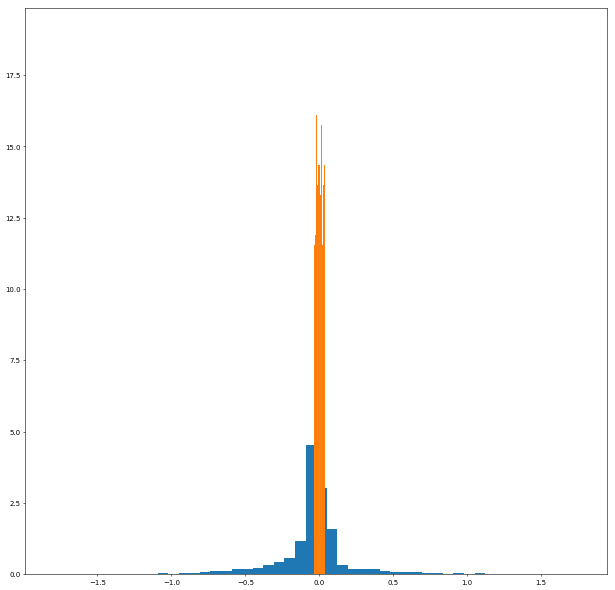

initial distributions in 1 pixel


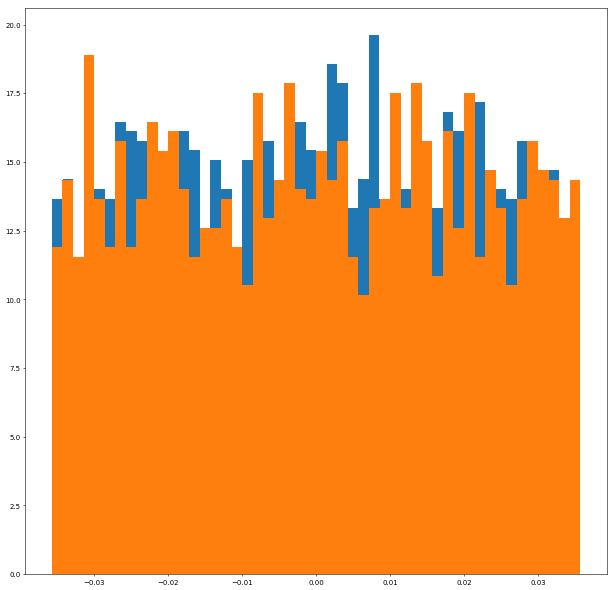

finding means for the models...
test model1
{'nll': 0.01859445530772209, 'loss': 0.01859445530772209, 'accuracy': 99.85}
{'nll': 0.2133816654443741, 'loss': 0.2133816654443741, 'accuracy': 98.09}
test model2
{'nll': 0.01806084686269751, 'loss': 0.01806084686269751, 'accuracy': 99.86166666666666}
{'nll': 0.23083926277160643, 'loss': 0.23083926277160643, 'accuracy': 98.03}
computing Arc2 model...
test Arc2
{'nll': 0.05067881688127915, 'loss': 0.05067881688127915, 'accuracy': 99.045}
{'nll': 0.2171219146490097, 'loss': 0.2171219146490097, 'accuracy': 97.29}
computing Arc model...
test Arc
{'nll': 0.05067884007394314, 'loss': 0.05067884007394314, 'accuracy': 99.045}
{'nll': 0.2171219436645508, 'loss': 0.2171219436645508, 'accuracy': 97.29}
computing Lin model...
{'nll': 0.14499299707015356, 'loss': 0.14499299707015356, 'accuracy': 95.06}
{'nll': 0.22273067784309386, 'loss': 0.22273067784309386, 'accuracy': 92.91}


In [26]:
model1.load_state_dict(torch.load('curves_mnist/LinearOneLayer/AdamRfree/curve1/checkpoint-30.pt')['model_state'])
model2.load_state_dict(torch.load('curves_mnist/LinearOneLayer/AdamRfree/curve2/checkpoint-30.pt')['model_state'])

model3.load_state_dict(torch.load('curves_mnist/LinearOneLayer/AdamRfree/curve1/checkpoint-0.pt')['model_state'])
model4.load_state_dict(torch.load('curves_mnist/LinearOneLayer/AdamRfree/curve2/checkpoint-0.pt')['model_state'])

look_at_models(model1, model2, model3, model4, architecture)

distance between train models 38.311127
distance between initial models 36.605488
how far model1 go 37.460575
how far model2 go 37.415936
initial singular values
train singular values
singular values distribution


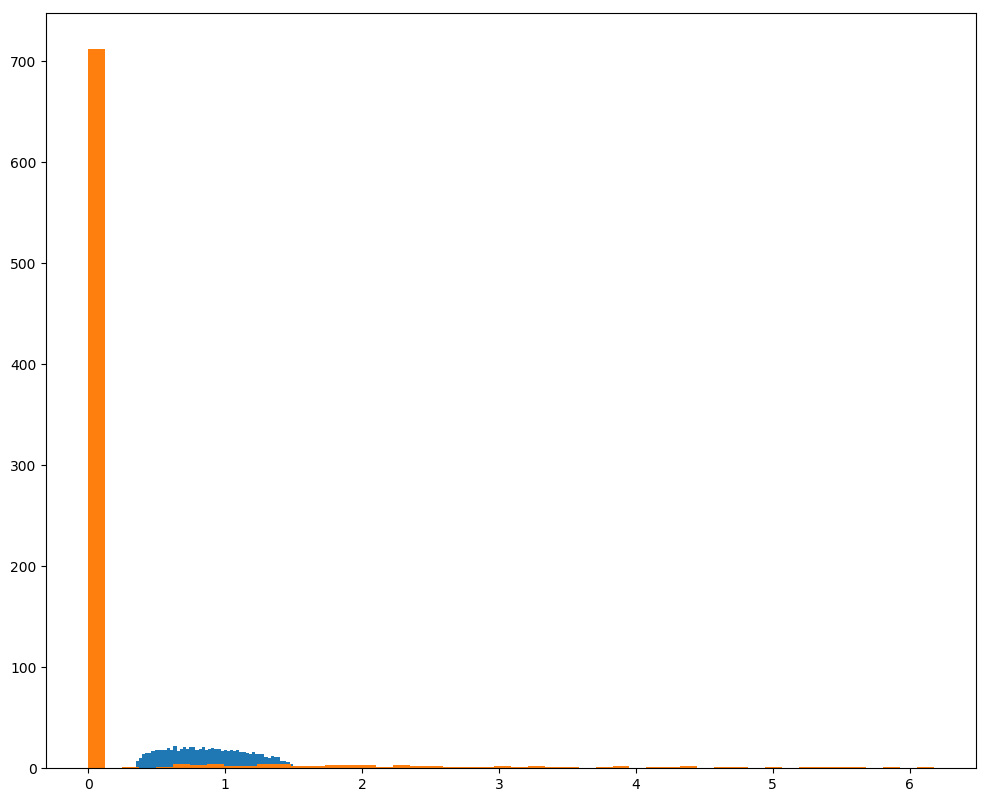

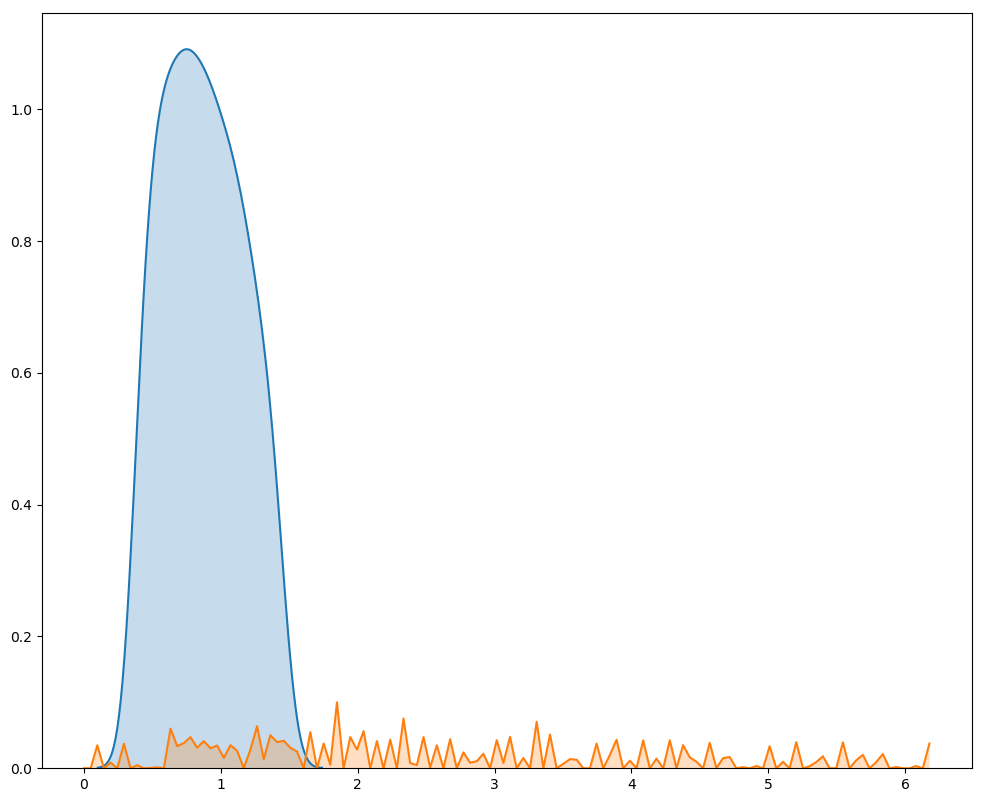

train models eigenvector heatmap


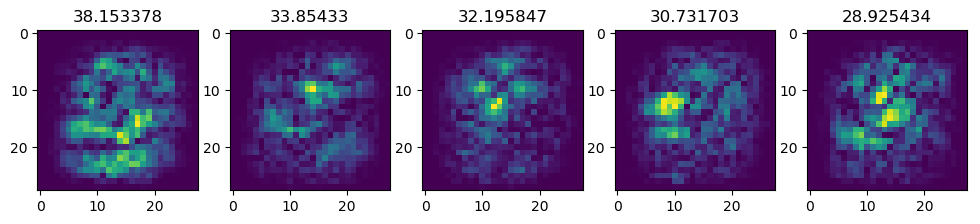

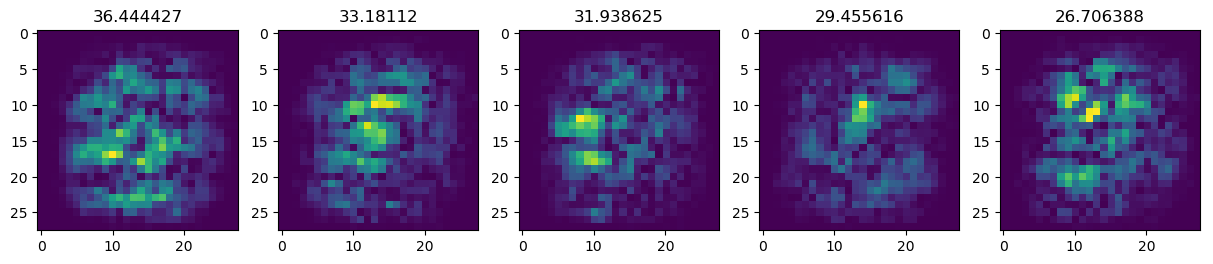

scalar product between train models
norms w1, w2 27.177952 27.135677
cos 0.004911071
neurons distributions...
train distribution in 500 pixel


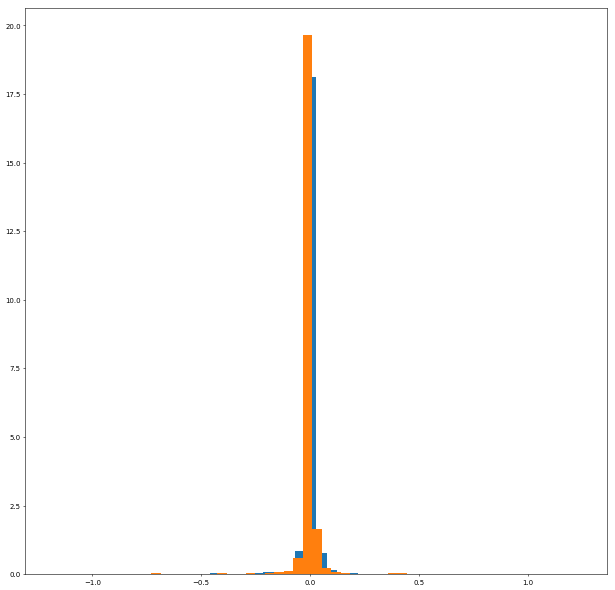

train distribution in 1 pixel


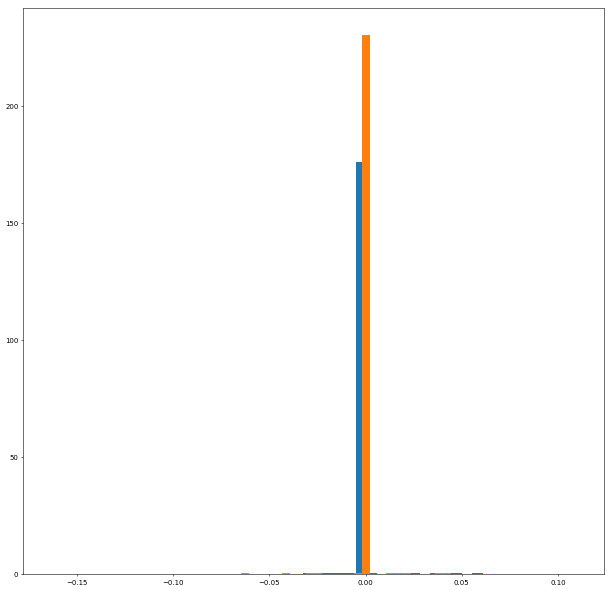

distribution in 500 pixel, train and initial model1 


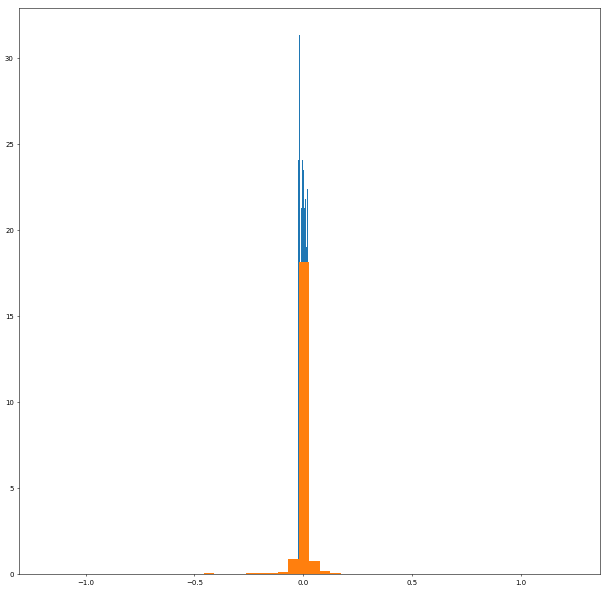

distribution in 500 pixel, train and initial model2 


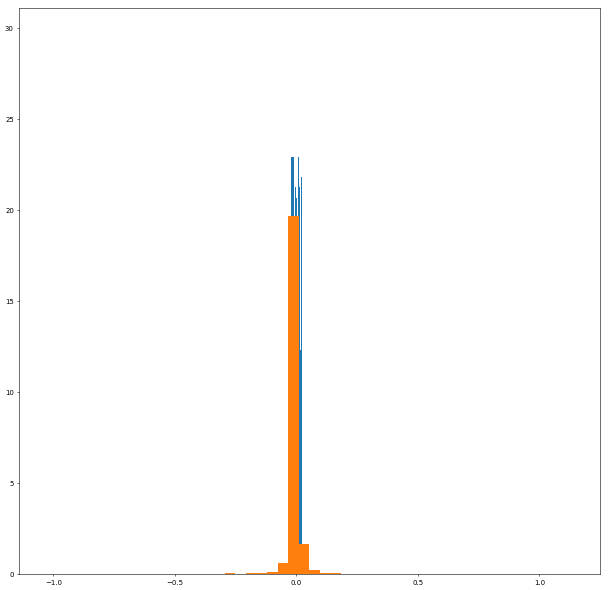

distribution in 1 pixel, train and initial model1 


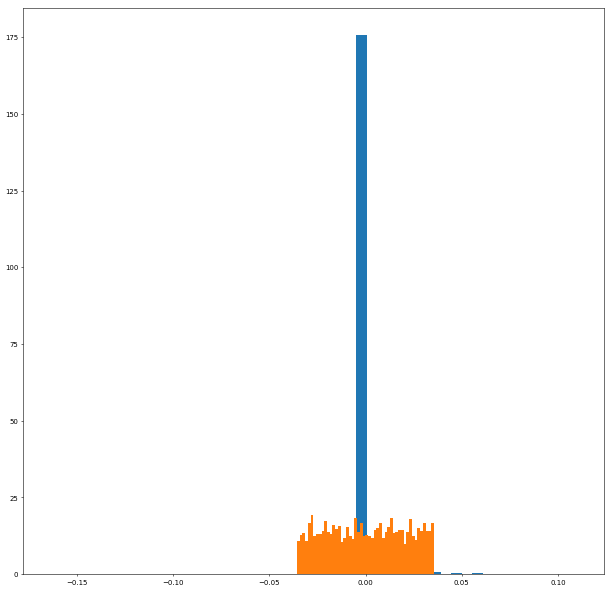

distribution in 1 pixel, train and initial model2 


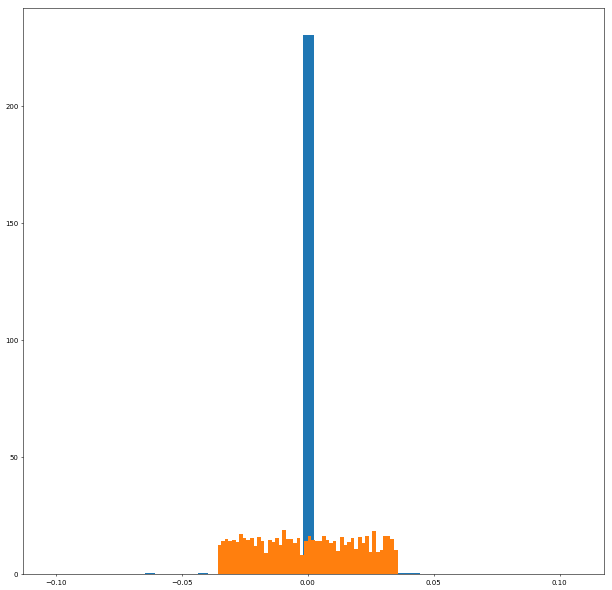

initial distributions in 1 pixel


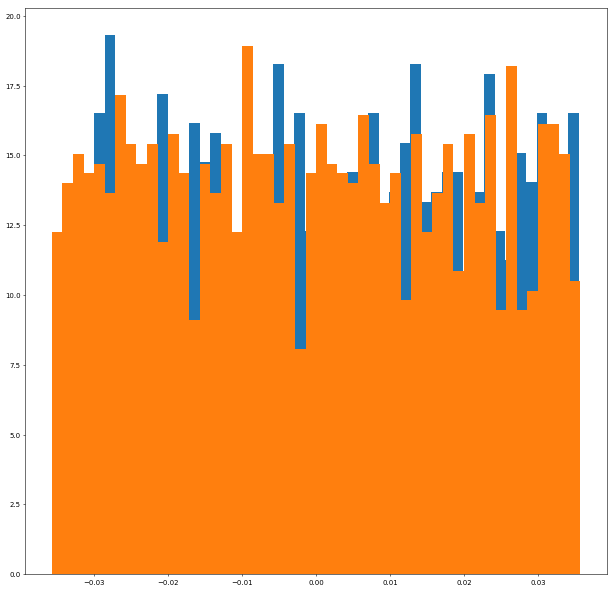

finding means for the models...
test model1
{'nll': 0.01322651330580314, 'loss': 0.01322651330580314, 'accuracy': 99.80666666666667}
{'nll': 0.059089827513694765, 'loss': 0.059089827513694765, 'accuracy': 98.14}
test model2
{'nll': 0.012396730812390646, 'loss': 0.012396730812390646, 'accuracy': 99.82833333333333}
{'nll': 0.05553358361721039, 'loss': 0.05553358361721039, 'accuracy': 98.37}
computing Arc2 model...
test Arc2
{'nll': 0.016384912725289663, 'loss': 0.016384912725289663, 'accuracy': 99.67833333333333}
{'nll': 0.05703975937366486, 'loss': 0.05703975937366486, 'accuracy': 98.13}
computing Arc model...
test Arc
{'nll': 0.016384913303951424, 'loss': 0.016384913303951424, 'accuracy': 99.67833333333333}
{'nll': 0.05703976142406464, 'loss': 0.05703976142406464, 'accuracy': 98.13}
computing Lin model...
{'nll': 0.07027011463840803, 'loss': 0.07027011463840803, 'accuracy': 99.59166666666667}
{'nll': 0.09578587112426758, 'loss': 0.09578587112426758, 'accuracy': 98.09}


In [227]:
model1.load_state_dict(torch.load('curves_mnist/LinearOneLayer/Adam/curve5/checkpoint-30.pt')['model_state'])
model2.load_state_dict(torch.load('curves_mnist/LinearOneLayer/Adam/curve6/checkpoint-30.pt')['model_state'])

model3.load_state_dict(torch.load('curves_mnist/LinearOneLayer/Adam/curve5/checkpoint-0.pt')['model_state'])
model4.load_state_dict(torch.load('curves_mnist/LinearOneLayer/Adam/curve6/checkpoint-0.pt')['model_state'])

look_at_models(model1, model2, model3, model4, architecture)

distance between train models 61.938835
distance between initial models 63.41444
how far model1 go 14.1077795
how far model2 go 14.107901
initial singular values
train singular values
singular values distribution


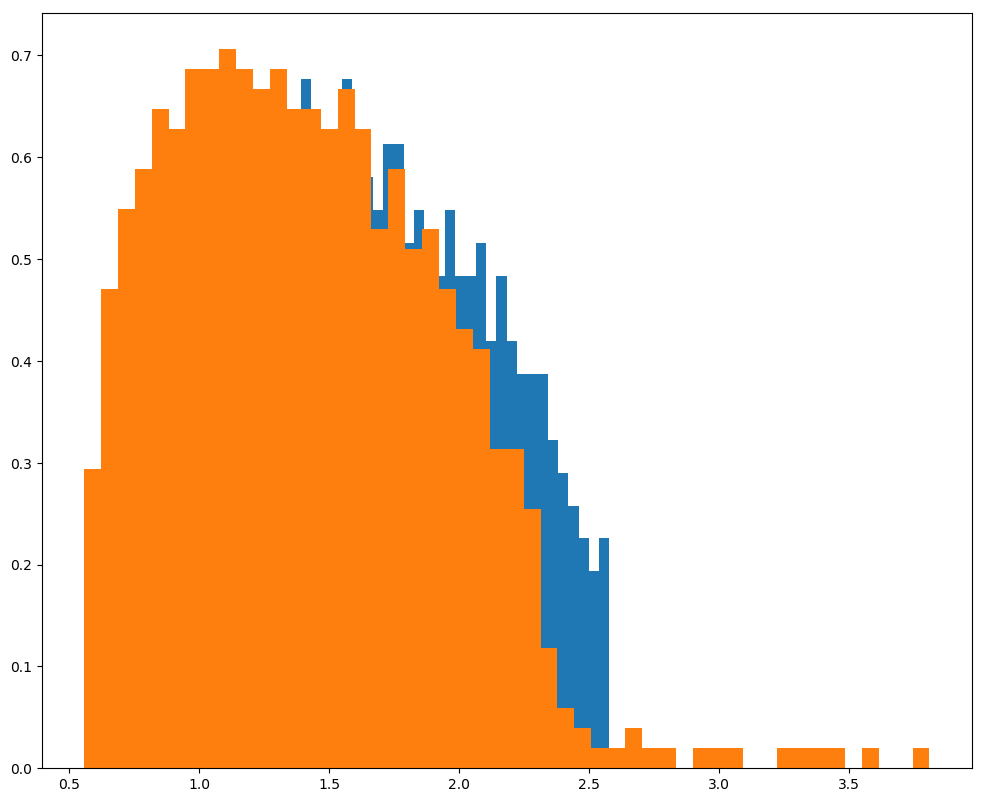

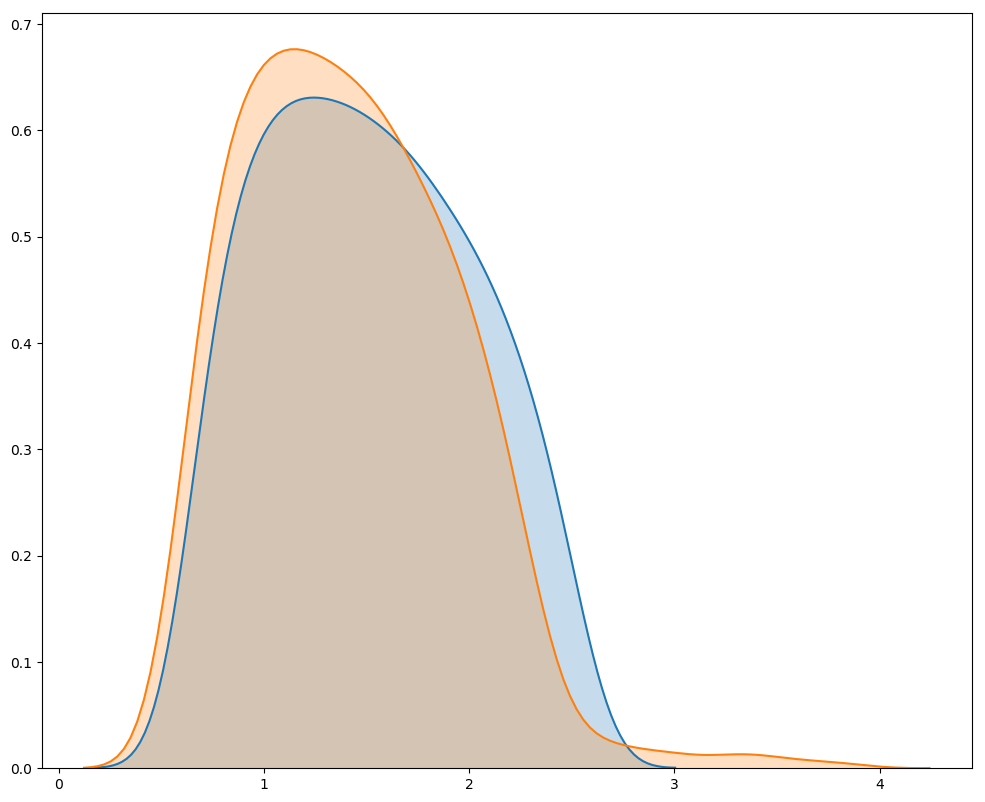

train models eigenvector heatmap


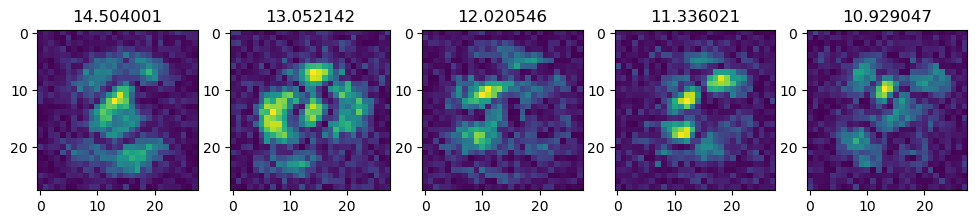

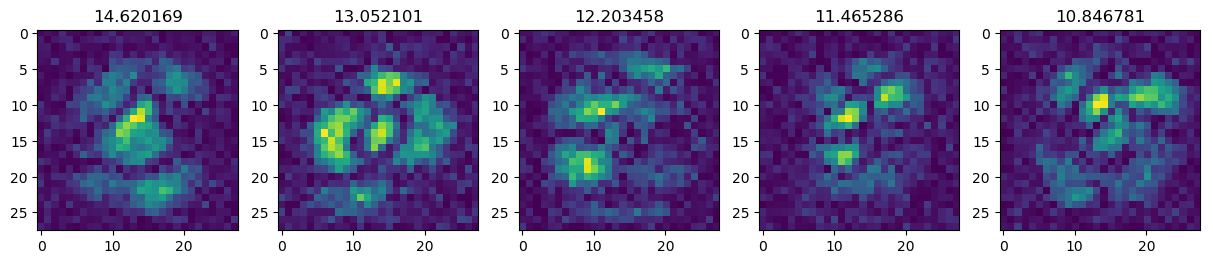

scalar product between train models
norms w1, w2 43.831146 43.815872
cos 0.0011926119
neurons distributions...
train distribution in 500 pixel


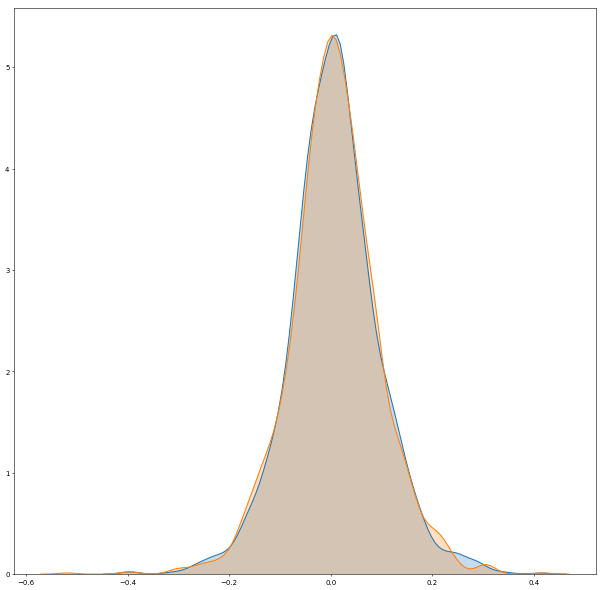

train distribution in 1 pixel


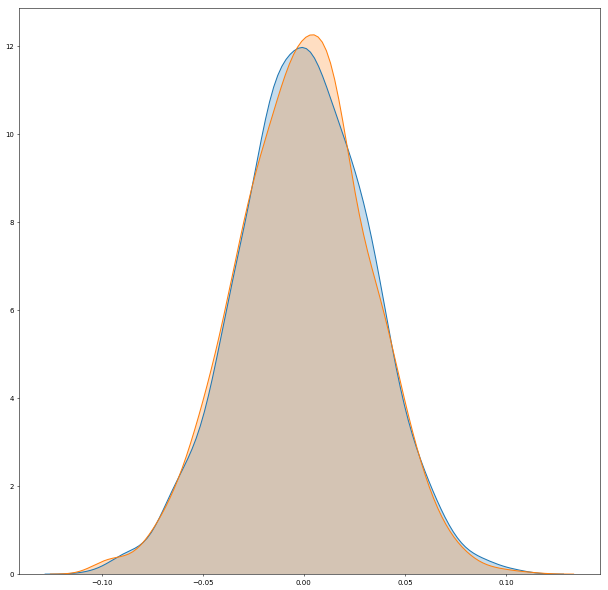

distribution in 500 pixel, train and initial model1 


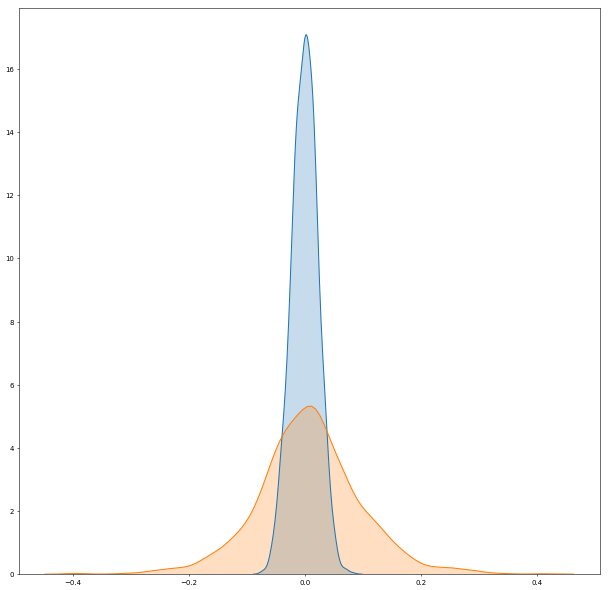

distribution in 500 pixel, train and initial model2 


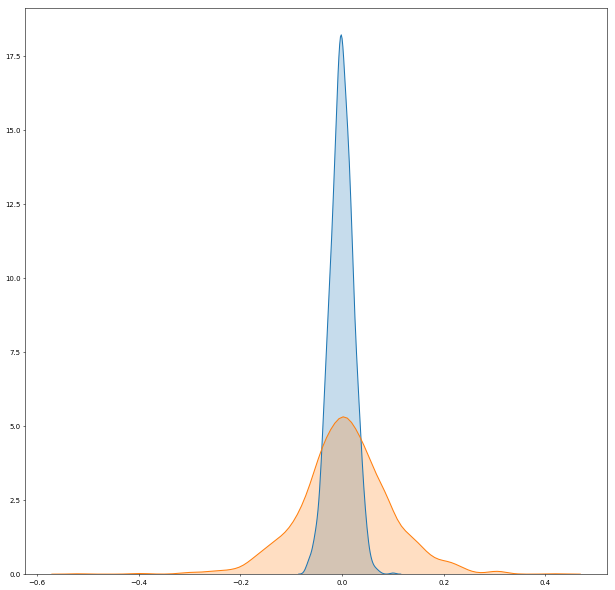

distribution in 1 pixel, train and initial model1 


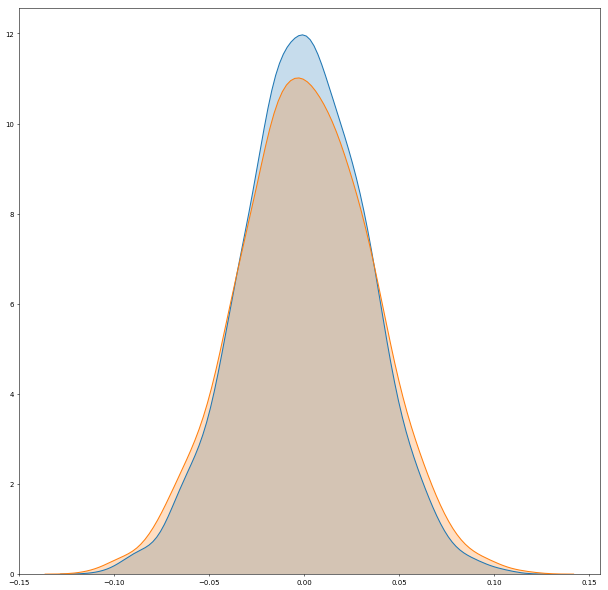

distribution in 1 pixel, train and initial model2 


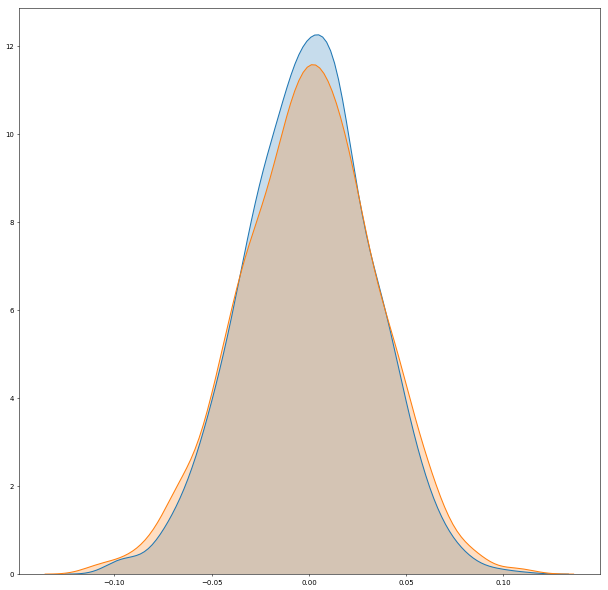

initial distributions in 1 pixel


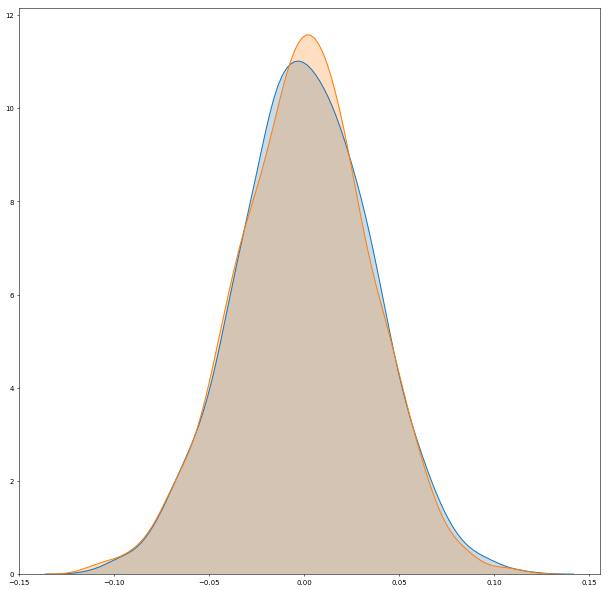

finding means for the models...
test model1
{'nll': 0.03861326831082503, 'loss': 0.03861326831082503, 'accuracy': 99.16833333333334}
{'nll': 0.0688511297941208, 'loss': 0.0688511297941208, 'accuracy': 97.98}
test model2
{'nll': 0.038219544409712154, 'loss': 0.038219544409712154, 'accuracy': 99.185}
{'nll': 0.06926937537193298, 'loss': 0.06926937537193298, 'accuracy': 98.0}
computing Arc2 model...
test Arc2
{'nll': 0.08245245258013408, 'loss': 0.08245245258013408, 'accuracy': 97.76166666666667}
{'nll': 0.10653210537433624, 'loss': 0.10653210537433624, 'accuracy': 96.79}
computing Arc model...
test Arc
{'nll': 0.08245245343248049, 'loss': 0.08245245343248049, 'accuracy': 97.76166666666667}
{'nll': 0.10653210690021515, 'loss': 0.10653210690021515, 'accuracy': 96.79}
computing Lin model...
{'nll': 0.2591213516076406, 'loss': 0.2591213516076406, 'accuracy': 96.39}
{'nll': 0.2663121936321259, 'loss': 0.2663121936321259, 'accuracy': 95.62}


In [193]:
model1.load_state_dict(torch.load('curves_mnist/LinearOneLayer/GaussianInit/curve5/checkpoint-30.pt')['model_state'])
model2.load_state_dict(torch.load('curves_mnist/LinearOneLayer/GaussianInit/curve6/checkpoint-30.pt')['model_state'])

model3.load_state_dict(torch.load('curves_mnist/LinearOneLayer/GaussianInit/curve5/checkpoint-0.pt')['model_state'])
model4.load_state_dict(torch.load('curves_mnist/LinearOneLayer/GaussianInit/curve6/checkpoint-0.pt')['model_state'])

look_at_models(model1, model2, model3, model4, architecture)

In [194]:
# model5 = architecture.base(num_classes=10, **architecture.kwargs)
# m = architecture.base(num_classes=10, **architecture.kwargs)
# model_Arc = architecture.base(num_classes=10, **architecture.kwargs)
# model_Arc2 = architecture.base(num_classes=10, **architecture.kwargs)

# mu1 = architecture.base(num_classes=10, **architecture.kwargs)
# mu2 = architecture.base(num_classes=10, **architecture.kwargs)
# mu = architecture.base(num_classes=10, **architecture.kwargs)

# mu1.load_state_dict(torch.load('curves_mnist/LinearOneLayer/curve3/E_model-100.pt')['model_state'])
# mu2.load_state_dict(torch.load('curves_mnist/LinearOneLayer/curve4/E_model-100.pt')['model_state'])
# mu.load_state_dict(torch.load('curves_mnist/LinearOneLayer/curve3/E-100.pt')['model_state'])

# mu.load_state_dict(torch.load('curves_mnist/LinearOneLayer/curve3/EC-100.pt')['model_state'])

# model1.load_state_dict(torch.load('curves_mnist/LinearOneLayer/curve3/checkpoint-12.pt')['model_state'])
# model2.load_state_dict(torch.load('curves_mnist/LinearOneLayer/curve4/checkpoint-12.pt')['model_state'])

# model1.load_state_dict(torch.load('curves_mnist/LinearOneLayer/LongTraining//curve1/checkpoint-30.pt')['model_state'])
# model2.load_state_dict(torch.load('curves_mnist/LinearOneLayer/LongTraining//curve2/checkpoint-30.pt')['model_state'])

# # model3.load_state_dict(torch.load('curves_mnist/LinearOneLayer/curve3/checkpoint-0.pt')['model_state'])
# # model4.load_state_dict(torch.load('curves_mnist/LinearOneLayer/curve4/checkpoint-0.pt')['model_state'])

# model3.load_state_dict(torch.load('curves_mnist/LinearOneLayer/LongTraining/curve1/checkpoint-0.pt')['model_state'])
# model4.load_state_dict(torch.load('curves_mnist/LinearOneLayer/LongTraining/curve2/checkpoint-0.pt')['model_state'])
# model_Arc.load_state_dict(torch.load('curves_mnist/LinearOneLayer/curve3/checkpoint-12.pt')['model_state'])
# model4.load_state_dict(torch.load('curves_mnist/LinearOneLayer/curve4/checkpoint-12.pt')['model_state'])

In [195]:
w1 = get_vector(model1)
w2 = get_vector(model2)
E1 = get_vector(mu1)
E2 = get_vector(mu2)
E = get_vector(mu)

NameError: name 'mu1' is not defined

In [45]:
np.linalg.norm(w1), np.linalg.norm(w2), np.linalg.norm(E1), np.linalg.norm(E2), np.linalg.norm(E) 

(28.284746, 28.291592, 1.2700168, 1.2678005, 1.0888693)

In [46]:
np.sqrt(np.linalg.norm(w2)**2+np.linalg.norm(w1)**2)

40.00551241605226

In [47]:
(w1*w2).sum()

2.4904242

In [123]:
(E1*E2).sum()/(np.linalg.norm(E1)*np.linalg.norm(E2))

0.80601543

In [21]:
print(distance(model1, model2))
print(distance(model3, model4))
print(distance(model1, model3))
print(distance(model2, model4))
print(distance(mu1, mu2))
print(distance(mu, mu2))

38.22829
36.60448
37.402473
37.32382
0.79037106
0.5544214


In [125]:
E

array([ 1.3621068e-06,  2.1078683e-04,  1.3464248e-05, ...,
        8.5102528e-02, -1.1999851e-01, -1.7114852e-02], dtype=float32)

In [126]:
E1

array([-8.60317305e-05,  4.04028979e-04,  2.67845200e-04, ...,
        1.01917155e-01, -1.17530577e-01, -3.22388834e-03], dtype=float32)

In [127]:
E2

array([ 1.2173269e-04,  2.1451368e-04, -2.0166003e-04, ...,
        7.5441964e-02, -1.2837268e-01, -1.8431428e-03], dtype=float32)

In [128]:
# ind = 1
# T = True

# while ind<22:

#     ckpt = 'curves_mnist/LinearOneLayer/curve'+str(2+ind)+'/checkpoint-12.pt'
#     checkpoint = torch.load(ckpt)
#     m.load_state_dict(checkpoint['model_state'])
    
#     for parameter, p in zip(model4.parameters(), m.parameters()):
#         if ind == 1:
#             parameter.data.copy_((p))
#         else:
#             parameter.data.copy_((parameter+p))
            
#     ind+=1

# print('ind', ind)
# for parameter in model4.parameters():
#     parameter.data.copy_(parameter/ind)
    
# checkpoints = torch.load('curves_mnist/LinearOneLayer/curve3/checkpoint-12.pt')

# print("Saving checkpoint for node changing")

# utils.save_checkpoint(
#             'curves_mnist/LinearOneLayer/curve3',
#             100,
#             name='E',
#             model_state=model4.state_dict(),
#             optimizer_state=checkpoints['optimizer_state']
#             )


In [129]:
list(model4.parameters())[0]

Parameter containing:
tensor([[ 0.0268,  0.0297, -0.0229,  ..., -0.0325,  0.0097,  0.0044],
        [-0.0070, -0.0267, -0.0086,  ..., -0.0272,  0.0033,  0.0344],
        [ 0.0061,  0.0202,  0.0168,  ..., -0.0034, -0.0287, -0.0018],
        ...,
        [ 0.0114,  0.0252, -0.0230,  ...,  0.0144,  0.0325, -0.0265],
        [ 0.0159,  0.0269,  0.0199,  ...,  0.0206,  0.0218, -0.0099],
        [ 0.0230,  0.0255,  0.0051,  ...,  0.0318, -0.0192,  0.0121]],
       requires_grad=True)

In [130]:
# for parameter in model4.parameters():
#     parameter.data.copy_(0*parameter)
    
# checkpoints = torch.load('curves_mnist/LinearOneLayer/curve3/checkpoint-12.pt')

# print("Saving checkpoint for node changing")

# utils.save_checkpoint(
#             'curves_mnist/LinearOneLayer/curve3',
#             100,
#             name='Zero',
#             model_state=model4.state_dict(),
#             optimizer_state=checkpoints['optimizer_state']
#             )

In [122]:
# class LinearOneLayerBase(nn.Module):
#     def __init__(self, num_classes, in_dim):
#         super(LinearOneLayerBase, self).__init__()
#         self.fc = nn.Sequential(
#             nn.Linear(in_dim, 2000),
#             nn.ReLU(True),
#             nn.Linear(2000, num_classes),
#         )
        
#         for m in self.modules():
#             if isinstance(m, nn.Linear):
# #                 print('dd')
#                 n = 28*28
# #                 n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
#                 m.weight.data.normal_(0, np.sqrt(2. / n))
#                 m.bias.data.zero_()


#     def forward(self, x):
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
#         return x

In [123]:
# model2 = LinearOneLayerBase(10, 784)
# model1 = LinearOneLayerBase(10, 784)

# list(model1.parameters())[0].requires_grad = False
# list(model1.parameters())[1].requires_grad = False

In [124]:
# S_initial1 = samples(model1)
# S_initial2 = samples(model2)

In [125]:
# sns.kdeplot(S_initial1[:, 1], S_initial1[:, 2], shade=True,  cbar=True)

In [126]:
# sns.kdeplot(S1[:, -1], S1[:, -2], shade=True,  cbar=True)

In [127]:
# sns.kdeplot(S_initial2[:, -1], S_initial2[:, -2], shade=True,  cbar=True)

In [128]:
# sns.kdeplot(S2[:, -1], S2[:, -2], shade=True,  cbar=True)

In [129]:
# model1.cuda()
# optimizer = torch.optim.SGD(
#     filter(lambda param: param.requires_grad, model1.parameters()),
#     lr=1,
#     weight_decay=0.
# )

# columns = ['ep', 'lr', 'tr_loss', 'tr_acc', 'te_nll', 'te_acc', 'time']
# for epoch in range(0, 10 + 1):
#     time_ep = time.time()

#     train_res = utils.train(loaders['train'], model1, optimizer, criterion, regularizer, cuda=True)
#     test_res = utils.test(loaders['test'], model1, criterion, regularizer, cuda=True)

#     time_ep = time.time() - time_ep
#     values = [epoch, lr, train_res['loss'], train_res['accuracy'], test_res['nll'],
#               test_res['accuracy'], time_ep]

#     table = tabulate.tabulate([values], columns, tablefmt='simple', floatfmt='9.4f')
#     print(table)

In [130]:
# model2.cuda()
# optimizer = torch.optim.SGD(
#     filter(lambda param: param.requires_grad, model2.parameters()),
#     lr=1,
#     weight_decay=0.
# )

# columns = ['ep', 'lr', 'tr_loss', 'tr_acc', 'te_nll', 'te_acc', 'time']
# for epoch in range(0, 10 + 1):
#     time_ep = time.time()

#     train_res = utils.train(loaders['train'], model2, optimizer, criterion, regularizer, cuda=True)
#     test_res = utils.test(loaders['test'], model2, criterion, regularizer, cuda=True)

#     time_ep = time.time() - time_ep
#     values = [epoch, lr, train_res['loss'], train_res['accuracy'], test_res['nll'],
#               test_res['accuracy'], time_ep]

#     table = tabulate.tabulate([values], columns, tablefmt='simple', floatfmt='9.4f')
#     print(table)

In [131]:
# distance(model1, model2)

In [133]:
# model1.cpu();
# S1 = samples(model1)
# model2.cpu();
# S2 = samples(model2)

In [134]:
# def get_importante_weights(S, koef=0.01):
#     mask = np.zeros(795)
#     mask[S[:, :].var(axis=0)>koef]=1
#     mask = mask[:784].reshape((28, 28))
#     return mask

In [135]:
# mask1 = get_importante_weights(S1, koef=0.001)
# mask2 = get_importante_weights(S2, koef=0.001)

In [780]:
# mask1

In [136]:
def find_masked_distance(mask1, mask2, S_initial1, S_initial2):

    mask = mask1*mask2
    mask = mask.reshape(-1).astype(int)
    S_initial1, S_initial2 = S_initial1[:, :784], S_initial2[:, :784]
    S_initial1, S_initial2 = S_initial1[: :]*mask, S_initial2[:, :]*mask
    dx = S_initial1 - S_initial2
    distance = np.sqrt((dx*dx).sum())
    return distance

In [139]:
# a = find_masked_distance(mask1, mask2, S1, S2)
# a

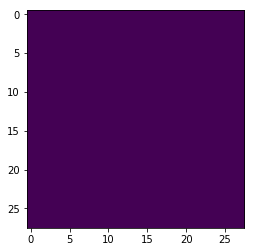

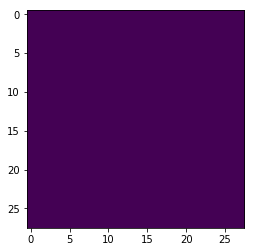

In [777]:
plt.imshow(mask1)
plt.show()
plt.imshow(mask2)

In [795]:
# train_res = utils.test(loaders['train'], model1, criterion, regularizer)
# test_res = utils.test(loaders['test'], model1, criterion, regularizer) 
# train_res, test_res

In [796]:
for parameter, p1, p2 in zip(model5.parameters(), model1.parameters(), model2.parameters()):
    parameter.data.copy_((p1+p2)/2)

In [800]:
criterion = F.cross_entropy
regularizer = None 
optimizer = torch.optim.SGD(
    filter(lambda param: param.requires_grad, model3.parameters()),
    lr=0.01,
    momentum=0.9,
    weight_decay=0.0
)

In [802]:
list(model_Arc.parameters())[-1]

Parameter containing:
tensor([ 0.0019, -0.0058,  0.0146,  0.0130, -0.0033, -0.0084,  0.0086,  0.0032,
         0.0040,  0.0099], requires_grad=True)

In [803]:
list(model1.parameters())[-1]

Parameter containing:
tensor([-0.0120,  0.1344, -0.2833, -0.2432, -0.0804,  0.1758,  0.0160, -0.2058,
         0.2666,  0.2318], requires_grad=True)

In [804]:
list(model2.parameters())[-1]

Parameter containing:
tensor([-0.2141, -0.4169, -0.2648, -0.3136,  0.0217, -0.1371,  0.3147, -0.6727,
         1.4842,  0.1983], requires_grad=True)

In [805]:
train_res = utils.test(loaders['train'], model_Arc, criterion, regularizer)
test_res = utils.test(loaders['test'], model_Arc, criterion, regularizer) 
train_res, test_res

({'nll': 0.10031545708576838, 'loss': 0.10031545708576838, 'accuracy': 96.815},
 {'nll': 0.1456833489894867, 'loss': 0.1456833489894867, 'accuracy': 95.49})

In [806]:
train_res = utils.test(loaders['train'], model5, criterion, regularizer)
test_res = utils.test(loaders['test'], model5, criterion, regularizer) 
train_res, test_res

({'nll': 0.22981266481876372,
  'loss': 0.22981266481876372,
  'accuracy': 96.25166666666667},
 {'nll': 0.2497264081954956, 'loss': 0.2497264081954956, 'accuracy': 95.0})

In [807]:
train_res = utils.test(loaders['train'], model1, criterion, regularizer)
test_res = utils.test(loaders['test'], model1, criterion, regularizer) 
train_res, test_res

({'nll': 0.06437447655002276, 'loss': 0.06437447655002276, 'accuracy': 98.12},
 {'nll': 0.1066709920167923, 'loss': 0.1066709920167923, 'accuracy': 96.85})

In [808]:
train_res = utils.test(loaders['train'], model4, criterion, regularizer)
test_res = utils.test(loaders['test'], model4, criterion, regularizer) 
train_res, test_res

({'nll': 2.1608021107991537,
  'loss': 2.1608021107991537,
  'accuracy': 22.321666666666665},
 {'nll': 2.1599566329956055, 'loss': 2.1599566329956055, 'accuracy': 22.4})

In [809]:
train_res = utils.test(loaders['train'], model2, criterion, regularizer)
test_res = utils.test(loaders['test'], model2, criterion, regularizer) 
train_res, test_res

({'nll': 0.0024662952263529102,
  'loss': 0.0024662952263529102,
  'accuracy': 99.99333333333334},
 {'nll': 0.0592628039598465, 'loss': 0.0592628039598465, 'accuracy': 98.32})

In [810]:
train_res = utils.test(loaders['train'], model3, criterion, regularizer)
test_res = utils.test(loaders['test'], model3, criterion, regularizer) 
train_res, test_res

({'nll': 2.3043077946980794,
  'loss': 2.3043077946980794,
  'accuracy': 7.826666666666667},
 {'nll': 2.30461701965332, 'loss': 2.30461701965332, 'accuracy': 7.87})

In [23]:
list(model1.parameters())[0].shape, list(model1.parameters())[1].shape, list(model1.parameters())[2].transpose(0,1).shape

(torch.Size([2000, 784]), torch.Size([2000]), torch.Size([2000, 10]))

## Compute mean weight vector for 1 and 2 models

In [45]:
def samples(model):
    p1 = list(model.parameters())[0].data.numpy()
    p2 = list(model.parameters())[1].data.numpy()
    p3 = list(model.parameters())[2].transpose(0,1).data.numpy()
    samples = np.hstack([p1, p2[:, None], p3])
    
    return samples

In [105]:
S1 = samples(model1)
S2 = samples(model2)
SE = samples(mu)

In [106]:
S1.mean(0, keepdims = True).shape

(1, 795)

In [108]:
S1_mean = np.repeat(S1.mean(0, keepdims = True), repeats=2000, axis=0)
S2_mean = np.repeat(S2.mean(0, keepdims = True), repeats=2000, axis=0)
SE_mean = np.repeat(SE.mean(0, keepdims = True), repeats=2000, axis=0)

In [109]:
S1_mean = np.repeat(S1.mean(0, keepdims = True), repeats=2000, axis=0)
S2_mean = np.repeat(S2.mean(0, keepdims = True), repeats=2000, axis=0)
B1 = list(model1.parameters())[-1].data
B2 = list(model2.parameters())[-1].data
BE = list(mu.parameters())[-1].data

In [110]:
B1.shape

torch.Size([10])

In [24]:
model_sampled = architecture.base(num_classes=10, **architecture.kwargs)
model_samples = SE_mean
B = BE
SIZE = 2000

offset = 0
for parameter in list(model_sampled.parameters())[:-1]:
    size = int(np.prod(parameter.size())/SIZE)
    value = model_samples[:, offset:offset+size]
    if size==10 or size==1:
         value = value.T
    print(value.shape)
    value = value.reshape(parameter.size())
    print(value.shape)
    parameter.data.copy_(torch.from_numpy(value))
    offset += size

list(model_sampled.parameters())[-1].data.copy_(B)

NameError: name 'SE_mean' is not defined

In [112]:
checkpoints = torch.load('curves_mnist/LinearOneLayer/curve3/checkpoint-12.pt')

utils.save_checkpoint(
            'curves_mnist/LinearOneLayer/curve3',
            100,
            name='EC',
            model_state=model_sampled.state_dict(),
            optimizer_state=checkpoints['optimizer_state']
            )

In [815]:
CM1 = np.cov(S1, rowvar=False)
CM2 = np.cov(S2, rowvar=False)

In [816]:
from scipy.stats import kde

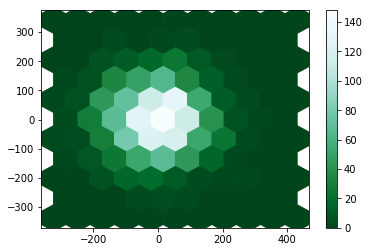

In [817]:
plt.hexbin(S1[:, 0], S1[:, 70], gridsize=10, cmap=plt.cm.BuGn_r)
plt.colorbar()

In [34]:
X_embedded1 = TSNE(n_components=2).fit_transform(S1)
X_embedded2 = TSNE(n_components=2).fit_transform(S2)

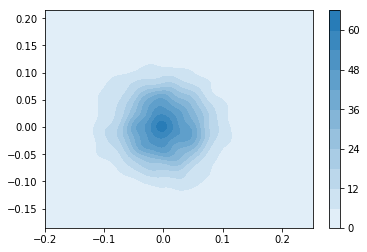

In [845]:
sns.kdeplot(S_initial1[:, 0], S_initial1[:, 790], shade=True,  cbar=True)

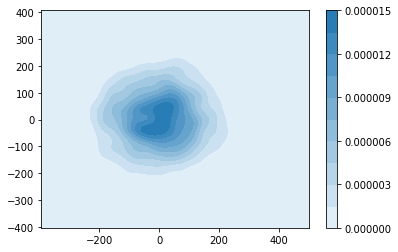

In [844]:
sns.kdeplot(S1[:, 0], S1[:, 70], shade=True,  cbar=True)

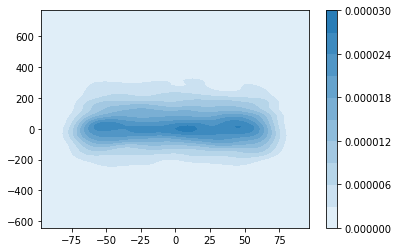

In [305]:
sns.kdeplot(S2[:, 0], S2[:, 790], shade=True,  cbar=True)

In [842]:
sns.kdeplot(X_embedded1[:, 0], X_embedded1[:, 1], shade=True, cbar=True)

NameError: name 'X_embedded1' is not defined

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


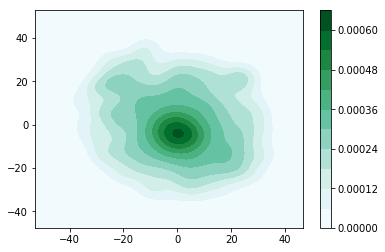

In [44]:
sns.kdeplot(X_embedded2[:, 0], X_embedded2[:, 1], shade=True, cbar=True)

In [45]:
from sklearn.decomposition import PCA

In [46]:
pca = PCA(n_components=2, svd_solver='full')
PCA1 = pca.fit_transform(S1)  
PCA2 = pca.fit_transform(S2)  

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


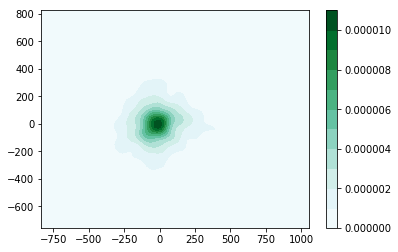

In [47]:
sns.kdeplot(PCA1[:, 0], PCA1[:, 1], shade=True, cbar=True)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


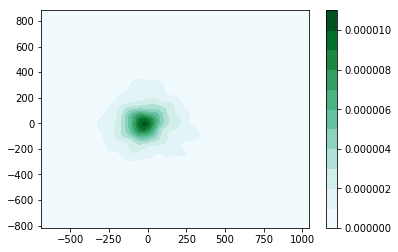

In [48]:
sns.kdeplot(PCA2[:, 0], PCA2[:, 1], shade=True, cbar=True)

## Let model distribution be gaussian, sample from it and see what results we get

In [820]:
ind = 1
T = True
S = []
B = []
# while ind<10:

#     ckpt = 'curves_mnist/LinearOneLayer/curve'+str(2+ind)+'/checkpoint-12.pt'
#     checkpoint = torch.load(ckpt)
#     m.load_state_dict(checkpoint['model_state'])
    
#     S.append(2000*samples(m))
#     B.append(list(m.parameters())[-1].data.numpy())
#     ind+=1

In [821]:
B.append(list(model1.parameters())[-1].data.numpy())

In [822]:
B = np.array(B)

In [837]:
B[0]

array([-0.01198832,  0.13439709, -0.28331888, -0.24317376, -0.08038262,
        0.17582034,  0.01595621, -0.20576544,  0.266556  ,  0.23180848],
      dtype=float32)

In [824]:
# S = np.vstack(S)

In [857]:
S = samples(model2)

In [858]:
S.shape

(2000, 795)

In [859]:
CM = np.cov(S, rowvar=False)

In [860]:
SIZE = 2000
model_samples = np.random.multivariate_normal(S.mean(0), CM, size=SIZE)

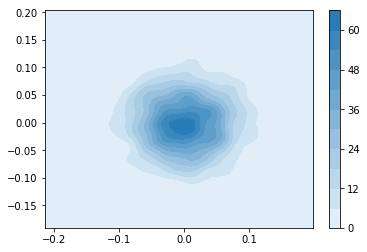

In [861]:
sns.kdeplot(model_samples[:, 0], model_samples[:, 1], shade=True, cbar=True)

In [862]:
model_sampled = architecture.base(num_classes=10, **architecture.kwargs)
# model_sampled.load_state_dict(torch.load('curves_mnist/LinearOneLayer/curve3/checkpoint-12.pt')['model_state'])

In [863]:
model_sampled = architecture.base(num_classes=10, **architecture.kwargs)

offset = 0
for parameter in list(model_sampled.parameters())[:-1]:
    size = int(np.prod(parameter.size())/SIZE)
    value = model_samples[:, offset:offset+size]
    if size==10 or size==1:
         value = value.T
    print(value.shape)
    value = value.reshape(parameter.size())
    print(value.shape)
    parameter.data.copy_(torch.from_numpy(value))
    offset += size

list(model_sampled.parameters())[-1].data.copy_(torch.from_numpy(B.mean(0)))

(2000, 784)
(2000, 784)
(1, 2000)
(2000,)
(10, 2000)
(10, 2000)


tensor([-0.0120,  0.1344, -0.2833, -0.2432, -0.0804,  0.1758,  0.0160, -0.2058,
         0.2666,  0.2318])

In [212]:
train_res = utils.test(loaders['train'], model_sampled, criterion, regularizer)
test_res = utils.test(loaders['test'], model_sampled, criterion, regularizer) 
train_res, test_res

({'nll': 2.598426075108846, 'loss': 2.598426075108846, 'accuracy': 9.035},
 {'nll': 2.6049694828033445, 'loss': 2.6049694828033445, 'accuracy': 8.92})

## What if train the model

In [865]:
int((795*795-795)/2+2*795)

317205

In [866]:
795*2000

1590000

In [867]:
28*28

784

In [868]:
loaders, num_classes = data.loaders(
    "MNIST",
    "data",
    128,
    1,
    "VGG",
    True
)

You are going to run models on the test set. Are you sure?


In [869]:
for X, y in loaders['test']:
    break

## Generator 

In [296]:
class Generator(nn.Module):
    def __init__(self, n_dim=795, N_layers=2):
        super(Generator, self).__init__()
        
        self.in_dim = 795
        self.proposal = nn.Sequential(nn.Linear(795, 795*2),
                                nn.Tanh(),
                                nn.Linear(795*2, 795),
                                nn.Tanh(),
                                nn.Linear(795, 795*2),
                                nn.Tanh(),
                                nn.Linear(795*2, 795),
                                nn.Tanh(),
#                                 nn.Linear(795, 795*2),
#                                 nn.Tanh(),
#                                 nn.Linear(795*2, 795),
#                                 nn.Tanh(),
                               )
        
        
        self.W1 = nn.Linear(795, 784)
        self.b1 = nn.Linear(795, 1)
        self.W2 = nn.Linear(795, 10)
        
        data_b2 = torch.FloatTensor(np.random.normal(size=(10, )))
        self.b2 = nn.Parameter(data = data_b2, requires_grad=True)
        
        self.relu = nn.ReLU()
        
        self.mult = torch.tensor([1/28]*785 + [1/np.sqrt(2000)]*10).cuda()

    def sample(self, K, cuda=True):
        
        if cuda:
            shape = torch.Size((K, self.in_dim))
            e = torch.cuda.FloatTensor(shape)
            torch.randn(shape, out=e) 
            e = 2*(e-0.5)
#             e = self.mult*e
        else:
            e = torch.randn((K, self.in_dim)).cuda()  
        return e
    
    def sample_weights(self, K, cuda=True):
        
        if cuda:
            shape = torch.Size((K, self.in_dim))
            e = torch.cuda.FloatTensor(shape)
            torch.rand(shape, out=e)  
        else:
            e = torch.rand((K, self.in_dim))  
            
        z = self.proposal(e)
        W1 = self.W1(z)
        b1 = self.b1(z)
        W2 = self.W2(z)
        
        e = torch.cat([W1, b1, W2], -1)
        return e

    def forward(self, x, K=2000):

        x = x.view(x.size(0), -1)
        e = self.sample(K)
        z = self.proposal(e)
        W1 = self.W1(z)
        b1 = self.b1(z)[:, 0]
        
        x = F.linear(x, W1, b1)
        x = self.relu(x)
        
#         for i in range(int(self.n_dim-784-10/2), 2):
#             Wi = W[:, 785+i]
#             bi = W[:, 786+i]
#             x = self.relu(Wi*x+bi)
        
        W2 = self.W2(z).transpose(0,1)
 

        x = F.linear(x, W2, self.b2) 
        x = 1/K*x

        return x

In [297]:
G = Generator()

In [298]:
G.cuda();

In [211]:
criterion = F.cross_entropy
regularizer = None 

In [302]:
optimizer = torch.optim.Adam(
    filter(lambda param: param.requires_grad, G.parameters()),
    lr=0.000001,
    weight_decay=0.
)

columns = ['ep', 'lr', 'tr_loss', 'tr_acc', 'te_nll', 'te_acc', 'time']
for epoch in range(0, 10 + 1):
    time_ep = time.time()

    train_res = utils.train(loaders['train'], G, optimizer, criterion, regularizer, cuda=True)
    test_res = utils.test(loaders['test'], G, criterion, regularizer, cuda=True)

    time_ep = time.time() - time_ep
    values = [epoch, lr, train_res['loss'], train_res['accuracy'], test_res['nll'],
              test_res['accuracy'], time_ep]

    table = tabulate.tabulate([values], columns, tablefmt='simple', floatfmt='9.4f')
    print(table)

  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   0     0.0000     0.1378    95.8117     0.1807    94.9700     5.8845
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   1     0.0000     0.1359    95.9000     0.1793    94.9700     5.8723
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   2     0.0000     0.1368    95.8833     0.1818    94.8900     5.8820
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   3     0.0000     0.1371    95.8900     0.1796    94.9700     5.8741
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   4  

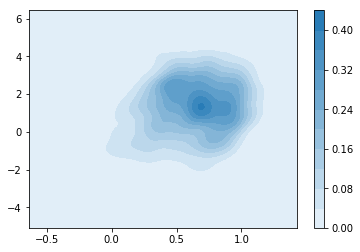

In [304]:
samples = G.sample_weights(2000).cpu().data.numpy()
sns.kdeplot(samples[:, 0], samples[:, 70], shade=True,  cbar=True)

In [99]:
optimizer = torch.optim.Adam(
    filter(lambda param: param.requires_grad, G.parameters()),
    lr=0.0001,
    weight_decay=0.
)

columns = ['ep', 'lr', 'tr_loss', 'tr_acc', 'te_nll', 'te_acc', 'time']
for epoch in range(0, 10 + 1):
    time_ep = time.time()

    train_res = utils.train(loaders['train'], G, optimizer, criterion, regularizer, cuda=True)
    test_res = utils.test(loaders['test'], G, criterion, regularizer, cuda=True)

    time_ep = time.time() - time_ep
    values = [epoch, lr, train_res['loss'], train_res['accuracy'], test_res['nll'],
              test_res['accuracy'], time_ep]

    table = tabulate.tabulate([values], columns, tablefmt='simple', floatfmt='9.4f')
    print(table)

  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   0     0.0000     0.1212    96.3533     0.1743    95.7300     5.7522
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   1     0.0000     0.1116    96.5467     0.1623    95.6400     5.7388
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   2     0.0000     0.1040    96.7817     0.1624    95.8700     5.7500
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   3     0.0000     0.1013    96.8750     0.1676    96.0500     5.7654
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   4  

In [148]:
def di(samples1, samples2):
    dx = (samples1 - samples2)
    dictance = np.sqrt((dx*dx).sum())
    print(dictance)

In [150]:
S = [1/2000*G.sample_weights(2000).cpu().data.numpy() for _ in range(4)]


In [152]:
for i in range(4):
    for j in range(i+1, 4):
        print(i, j) 
        di(S[i], S[j])

0 1
6.028146
0 2
5.991811
0 3
6.0165396
1 2
6.0026054
1 3
6.0141177
2 3
5.9938226


In [ ]:
optimizer = torch.optim.Adam(
    filter(lambda param: param.requires_grad, G.parameters()),
    lr=0.01,
    weight_decay=0.
)
columns = ['ep', 'lr', 'tr_loss', 'tr_acc', 'te_nll', 'te_acc', 'time']
for epoch in range(0, 10 + 1):
    time_ep = time.time()

#     utils.adjust_learning_rate(optimizer, lr)

    train_res = utils.train(loaders['train'], G, optimizer, criterion, regularizer)
    test_res = utils.test(loaders['test'], G, criterion, regularizer)

    time_ep = time.time() - time_ep
    values = [epoch, lr, train_res['loss'], train_res['accuracy'], test_res['nll'],
              test_res['accuracy'], time_ep]

    table = tabulate.tabulate([values], columns, tablefmt='simple', floatfmt='9.4f')
    print(table)

  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   0     0.0010     2.2896    11.5267     2.2839    11.1000   244.8504


In [116]:
columns = ['ep', 'lr', 'tr_loss', 'tr_acc', 'te_nll', 'te_acc', 'time']
for epoch in range(0, 10 + 1):
    time_ep = time.time()

    lr = 1e-3
    utils.adjust_learning_rate(optimizer, lr)

    train_res = utils.train(loaders['train'], G, optimizer, criterion, regularizer)
    test_res = utils.test(loaders['test'], G, criterion, regularizer)

    time_ep = time.time() - time_ep
    values = [epoch, lr, train_res['loss'], train_res['accuracy'], test_res['nll'],
              test_res['accuracy'], time_ep]

    table = tabulate.tabulate([values], columns, tablefmt='simple', floatfmt='9.4f')
    print(table)

KeyboardInterrupt: 

In [112]:
optimizer = torch.optim.Adam(
    filter(lambda param: param.requires_grad, G.parameters()),
    lr=0.001,
    weight_decay=0.5
)
columns = ['ep', 'lr', 'tr_loss', 'tr_acc', 'te_nll', 'te_acc', 'time']
for epoch in range(0, 10 + 1):
    time_ep = time.time()

#     utils.adjust_learning_rate(optimizer, lr)

    train_res = utils.train(loaders['train'], G, optimizer, criterion, regularizer)
    test_res = utils.test(loaders['test'], G, criterion, regularizer)

    time_ep = time.time() - time_ep
    values = [epoch, lr, train_res['loss'], train_res['accuracy'], test_res['nll'],
              test_res['accuracy'], time_ep]

    table = tabulate.tabulate([values], columns, tablefmt='simple', floatfmt='9.4f')
    print(table)

  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   0     0.0010     1.7253    39.2683     2.1102    20.6800   214.1120
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   1     0.0010     2.1600    20.8400     2.2362    20.8700   227.0089
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   2     0.0010     2.2721    19.5883     2.2902    19.2900   504.5819


Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/anaconda3/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

## Flow Generator 

In [45]:
class SNet(nn.Module):
    def __init__(self, dim_in, dim_middle):
        super(SNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(dim_in, dim_middle),
            nn.Tanh(),
            nn.Linear(dim_middle, dim_middle),
            nn.Tanh(),
            nn.Linear(dim_middle, dim_in)
        )
        
    def forward(self, x):   
        x = self.fc(x)
        return x
    
class TNet(nn.Module):
    def __init__(self, dim_in, dim_middle):
        super(TNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(dim_in, dim_middle),
            nn.Tanh(),
            nn.Linear(dim_middle, dim_middle),
            nn.Tanh(),
            nn.Linear(dim_middle, dim_in),
        )
        
    def forward(self, x):   
        x = self.fc(x)
        return x

In [46]:
nets = SNet# a function that take no arguments and return a pytorch model, dim(X) -> dim(X)
nett = TNet# a function that take no arguments and return a pytorch model, dim(X) -> dim(X)

# Check nets and nett are working i.e., computing without errors
# Check that resulting dimensions s and t are the same and equal dim(X)
# ex_nets = nets(dim_in, dim_middle)
# ex_mett = nett(dim_in, dim_middle)

In [47]:
import numpy as np
N_layers = 3
masks = torch.Tensor((np.vstack([[1, 0]*N_layers, [0, 1]*N_layers]).T)) # torch.Tensor of size #number_of_coupling_layers x #dim(X)
# Check that when dim(X) == 2, the mask for every layer has just one 1.0 and one 0.0 elements.

In [48]:
from torch import distributions

In [49]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()
        
        # Create a flow
        # nets:  a function that return a pytocrn neurel network e.g., nn.Sequential, s = nets(), s: dim(X) -> dim(X)
        # nett:  a function that return a pytocrn neurel network e.g., nn.Sequential, t = nett(), t: dim(X) -> dim(X)
        # mask:  a torch.Tensor of size #number_of_coupling_layers x #dim(X)
        # prior: an object from torch.distributions e.g., torch.distributions.MultivariateNormal
        
        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
#         print('len', len(mask))
        self.t = torch.nn.ModuleList([nett(dim_in=795, dim_middle=1000) for _ in range(len(mask))])
        self.s = torch.nn.ModuleList([nets(dim_in=795, dim_middle=1000) for _ in range(len(mask))])
        
    def g(self, z):
        # Compute and return g(z) = x, 
        #    where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer   
        # z: a torch.Tensor of shape batchSize x 1 x dim(X)
        # return x: a torch.Tensor of shape batchSize x 1 x dim(X)
        for i, (s, t) in enumerate(zip(reversed(self.s), reversed(self.t))):
            m = self.mask[-i-1]
#             print('i', i, 'm', m)
#             print('z', z.shape)
            z = m*z +(1-m)*(z-t(m*z))*(-s(m*z)).exp()
        x = z
        return x

    def f(self, x):
        # Compute f(x) = z and log_det_Jakobian of f, 
        #    where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer   
        # x: a torch.Tensor, of shape batchSize x dim(X), is a datapoint
        # return z: a torch.Tensor of shape batchSize x dim(X), a hidden representations
        # return log_det_J: a torch.Tensor of len batchSize
        
        z = x
        log_det_J = 0
        for s, t, m in zip(self.s, self.t, self.mask):
            s_res = s(m*z)
            z = m*z +(1-m)*(z*s_res.exp()+t(m*z))
            log_det_J += ((1-m)*s_res).sum(-1)
        
        return z, log_det_J
    
    def log_prob(self,x):
        # Compute and return log p(x)
        # using the change of variable formula and log_det_J computed by f
        # return logp: torch.Tensor of len batchSize
        z, log_det_J = self.f(x)
        logp = self.prior.log_prob(z)
        
        return logp+log_det_J
        
    def sample(self, K): 
        # Draw and return batchSize samples from flow using implementation of g
        # return x: torch.Tensor of shape batchSize x 1 x dim(X)
        
#         m = MultivariateNormal(torch.zeros(batchSize), torch.eye(batchSize))
        z = self.prior.sample((K, ))
        x = self.g(z)
        
        return x

In [50]:
class Gaussian_Flow(nn.Module):
    def __init__(self, n_dim=795, N_layers=2):
        super(Gaussian_Flow, self).__init__()
        
        onezero = [0, 1]*n_dim
        masks = torch.Tensor([[onezero[:n_dim], onezero[1:n_dim+1]]]*N_layers)
        masks = masks.view(2*N_layers, -1)
#         print('masks', masks, masks.shape)
        prior = distributions.MultivariateNormal(torch.zeros(n_dim), torch.eye(n_dim))
        
        self.nvp = RealNVP(nets, nett, masks, prior)
        self.relu = nn.ReLU()
        data_b2 = torch.FloatTensor(np.random.normal(size=(10, )))
        self.b2 = nn.Parameter(data = data_b2, requires_grad=True)


    def forward(self, x, K=2000):

        x = x.view(x.size(0), -1)
        W = self.nvp.sample(K)
        W1 = W[:, :784]
        b1 = W[:, 784:785]
        W2 =  W[:, 785:].transpose(0,1)
        
        print('x', x.shape)
        print('W1', W1.shape)
        print('b1', b1.shape)
        x = F.linear(x, W1, b1[:, 0])
        print('x', x.shape)
#         x = W1 @ x #+ b1
        print(x.shape)
        x = self.relu(x)
#         print('W2', W2.shape)
        x = F.linear(x, W2, self.b2) 
        x = 1/K*x
        print(x.shape)
        return x

In [51]:
GF = Gaussian_Flow(n_dim=795, N_layers=1)

In [52]:
criterion = F.cross_entropy
regularizer = None 
optimizer = torch.optim.SGD(
    filter(lambda param: param.requires_grad, GF.parameters()),
    lr=0.01,
    momentum=0.9,
    weight_decay=0.0
)

In [53]:
columns = ['ep', 'lr', 'tr_loss', 'tr_acc', 'te_nll', 'te_acc', 'time']
for epoch in range(0, 10 + 1):
    time_ep = time.time()

    lr = 1e-3
    utils.adjust_learning_rate(optimizer, lr)

    train_res = utils.train(loaders['train'], GF, optimizer, criterion, regularizer)
    test_res = utils.test(loaders['test'], GF, criterion, regularizer)

    time_ep = time.time() - time_ep
    values = [epoch, lr, train_res['loss'], train_res['accuracy'], test_res['nll'],
              test_res['accuracy'], time_ep]

    table = tabulate.tabulate([values], columns, tablefmt='simple', floatfmt='9.4f')
    print(table)

x torch.Size([128, 784])
W1 torch.Size([2000, 784])
b1 torch.Size([2000, 1])
x torch.Size([128, 2000])
torch.Size([128, 2000])
torch.Size([128, 10])


Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/anaconda3/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

## Trainig mean and covariance matrix One hidden layer

In [18]:
class Gaussian_model(nn.Module):
    def __init__(self, n_dim=795):
        super(Gaussian_model, self).__init__()
        self.A = nn.Linear(n_dim, n_dim)
        self.relu = nn.ReLU()
        self.in_dim = n_dim
        data_mean = torch.FloatTensor(np.random.normal(size=(n_dim, )))
        self.mean= nn.Parameter(data = data_mean, requires_grad=True)
        
        data_b2 = torch.FloatTensor(np.random.normal(size=(10, )))
        self.b2 = nn.Parameter(data = data_b2, requires_grad=True)

    def sample(self, K, cuda=True):
        
        if cuda:
            shape = torch.Size((K, self.in_dim))
            e = torch.cuda.FloatTensor(shape)
            torch.randn(shape, out=e)   
        else:          
            e = torch.randn((K, self.in_dim))
        W = (self.mean + self.A(e))       
        return W
    

    def forward(self, x, K=20000):

        x = x.view(x.size(0), -1)
        W = self.sample(K)
        W1 = W[:, :784]
        b1 = W[:, 784:785]
        W2 =  W[:, 785:].transpose(0,1)
        
        x = F.linear(x, W1, b1[:, 0])
        x = self.relu(x)
        x = F.linear(x, W2, self.b2) 
        x = 1/K*x

        return x

In [19]:
GM = Gaussian_model()
GM.cuda();

In [22]:
criterion = F.cross_entropy
regularizer = None 
optimizer = torch.optim.Adam(
    filter(lambda param: param.requires_grad, GM.parameters()),
    lr=0.01,
#     momentum=0.9,
)

In [23]:
columns = ['ep', 'tr_loss', 'tr_acc', 'te_nll', 'te_acc', 'time']
for epoch in range(0, 10 + 1):
    time_ep = time.time()


    train_res = utils.train(loaders['train'], GM, optimizer, criterion, regularizer, cuda=True)
    test_res = utils.test(loaders['test'], GM, criterion, regularizer, cuda=True)

    time_ep = time.time() - time_ep
    values = [epoch, train_res['loss'], train_res['accuracy'], test_res['nll'],
              test_res['accuracy'], time_ep]

    table = tabulate.tabulate([values], columns, tablefmt='simple', floatfmt='9.4f')
    print(table)

  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
   0     0.3081    91.3167     0.2685    91.9900     7.5937
  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
   1     0.2685    92.0917     0.2484    93.2200     7.5749
  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
   2     0.2631    92.3567     0.2584    92.7600     7.6197
  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
   3     0.2607    92.3900     0.2583    92.8700     7.6181
  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
   4     0.2516    92.5583     0.2549    92.8400     7.6093
  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  -

In [884]:
# GM(X)[0]

In [887]:
# test_res = utils.test(loaders['test'], GM, criterion, regularizer, cuda=True)
# test_res

In [260]:
samples = GM.sample(2000).data.numpy()
sns.kdeplot(samples[:, 0], samples[:, 70], shade=True,  cbar=True)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


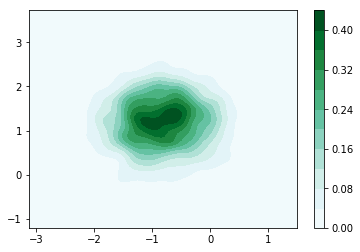

In [264]:
sns.kdeplot(samples[:, 0], samples[:, 70], shade=True,  cbar=True)

In [277]:
X_embeddeds = TSNE(n_components=2).fit_transform(samples)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


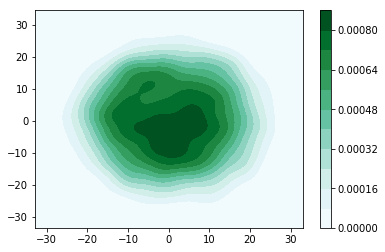

In [279]:
sns.kdeplot(X_embeddeds[:, 0], X_embeddeds[:, 1], shade=True,  cbar=True)

## Trainig mean and covariance matrix Several hidden layer

In [249]:
class GMMultyLayer(nn.Module):
    def __init__(self, n_dim=809):
        super(GMMultyLayer, self).__init__()
        self.n_dim = n_dim
        self.A = nn.Linear(n_dim, n_dim)
        self.relu = nn.ReLU()
        data_mean = torch.FloatTensor(np.random.normal(size=(n_dim, )))
        self.mean= nn.Parameter(data = data_mean, requires_grad=True)
        
        data_bf = torch.FloatTensor(np.random.normal(size=(10, )))
        self.bf = nn.Parameter(data = data_bf, requires_grad=True)

    def sample(self, K):
        e = torch.randn((K, self.mean.size()[0]))
        W = (self.mean + self.A(e))       
        return W
    

    def forward(self, x, K=4000):

        x = x.view(x.size(0), -1)
        W = self.sample(K)
        W1 = W[:, :784]
        b1 = W[:, 784]
        
        W2 = W[:, 785]
        b2 = W[:, 786]
        Wf =  W[:, -10:].transpose(0,1)
        
        x = F.linear(x, W1, b1)
        x = self.relu(x)
        for i in range(int(self.n_dim-784-10/2), 2):
            Wi = W[:, 785+i]
            bi = W[:, 786+i]
            x = self.relu(Wi*x+bi)
            
        x = F.linear(x, Wf, self.bf) 
        x = 1/K*x
#         print(x.shape)
        return x

In [250]:
GML = GMMultyLayer()

In [251]:
criterion = F.cross_entropy
regularizer = None 
optimizer = torch.optim.SGD(
    filter(lambda param: param.requires_grad, GML.parameters()),
    lr=0.01,
    momentum=0.9,
    weight_decay=0.0
)

In [252]:
columns = ['ep', 'lr', 'tr_loss', 'tr_acc', 'te_nll', 'te_acc', 'time']
for epoch in range(0, 10 + 1):
    time_ep = time.time()

    lr = 1e-3
    utils.adjust_learning_rate(optimizer, lr)

    train_res = utils.train(loaders['train'], GML, optimizer, criterion, regularizer)
    test_res = utils.test(loaders['test'], GML, criterion, regularizer)

    time_ep = time.time() - time_ep
    values = [epoch, lr, train_res['loss'], train_res['accuracy'], test_res['nll'],
              test_res['accuracy'], time_ep]

    table = tabulate.tabulate([values], columns, tablefmt='simple', floatfmt='9.4f')
    print(table)

  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   0     0.0010     2.7916    14.3017     2.2235    14.8000    93.5746
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   1     0.0010     2.1833    15.8317     2.1439    18.0300    91.0075
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   2     0.0010     2.0937    24.0500     2.0191    30.7600    90.9785
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   3     0.0010     1.9095    36.9383     1.7213    47.6100    90.6315
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   4  